# Validation curves
In this notebook we will try to train an estimator over the training data, and every epoch, perform a evaluation on both the training data and the validation data. With this data we will plot the validation curves of the algorithm. 

We will also try to implement a mechanism to persist and restorethe model which achieved the best performance overall on the validation set and at the end use it to evaluate the model's generalization ability on the test set.

In [1]:
%matplotlib inline
# standard library
import itertools
import sys, os
import re
import glob
import shutil

# pandas
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask


# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# skealrn
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score

# tesnsorflow
import tensorflow as tf

# local imports
sys.path.append(os.path.join(os.getcwd(), "../src"))

import tf_utils, tf_experiments

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

In [2]:
# define some constants
RANDOM_SEED = 42
BEST_CHECKPOINT_PATH = '/home/nikitautiu/models/best/best_cleaneval.ckpt'
MODEL_DIR = '/home/nikitautiu/models/cleaneval_curves/'

## Inputting the data
Using our in-memory caching dataset, we are going to load all the 3 datasets(train, validation, test) in memory.

In [3]:
# get the input functions and the initialization hooks to pass to the estimator
test_input_fn, test_init_hook = tf_utils.input_fn_from_csv('../data/final/cleaneval/dom-full-test-*.csv', precache=True)
train_input_fn, train_init_hook = tf_utils.input_fn_from_csv('../data/final/cleaneval/dom-full-train-*.csv', precache=True)
validation_input_fn, validation_init_hook = tf_utils.input_fn_from_csv('../data/final/cleaneval/dom-full-validation-*.csv', precache=True)

# define some shorthands
train_train_fn = lambda: train_input_fn(num_epochs=1, batch_size=2000, shuffle_buffer=50000)
train_eval_fn = lambda: train_input_fn(num_epochs=1, batch_size=5000, shuffle_buffer=0)
validation_fn = lambda: validation_input_fn(num_epochs=1, batch_size=5000, shuffle_buffer=0)
test_fn = lambda: test_input_fn(num_epochs=1, batch_size=5000, shuffle_buffer=0)

## Defining the model


In [4]:
# session workaround
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True

config = tf.estimator.RunConfig(
    model_dir=MODEL_DIR,
    save_checkpoints_steps=1000, 
    session_config=sess_config, 
    tf_random_seed=RANDOM_SEED
)

# we can infer the columns from the function, a bit costly, but better than hardcoding
tf_feat_cols = tf.contrib.learn.infer_real_valued_columns_from_input_fn(train_eval_fn)
estimator = tf.estimator.DNNClassifier(feature_columns=tf_feat_cols, hidden_units=(1000, 500, 200), 
                                        weight_column='weights', config=config)


INFO:tensorflow:Using config: {'_service': None, '_tf_random_seed': 42, '_model_dir': '/home/nikitautiu/models/cleaneval_curves/', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3590b53c88>, '_keep_checkpoint_max': 5, '_is_chief': True, '_master': '', '_task_type': 'worker', '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': None, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_save_checkpoints_steps': 1000, '_task_id': 0, '_session_config': gpu_options {
  allow_growth: true
}
, '_num_worker_replicas': 1}


Now that we have the model, we can build the infrastructure  for testing out the training process and returning the losses and other metrics.

## Train loop
We are running the train/eval loop for 1500 epochs. The best models for validation are persisted

In [8]:
%%time
metrics = tf_experiments.train_eval_loop(
    estimator=estimator, 
    train_input_fn_and_hook=(train_train_fn, train_init_hook),
    num_epochs=1500,
    eval_input_fns_and_hooks={'train':(train_eval_fn, train_init_hook), 'validation': (validation_fn, validation_init_hook)},
    save_on_metric='f1-score', best_checkpoint_path=BEST_CHECKPOINT_PATH, save_set_name='validation'
)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 1, loss = 322092.0
INFO:tensorflow:global_step/sec: 14.9636
INFO:tensorflow:step = 101, loss = 2752.19 (6.685 sec)
INFO:tensorflow:Saving checkpoints for 116 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 656.249.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-116
train  ----  {'epoch': 1, 'precision': 0.23964261407243292, 'support': 21849, 'recall': 0.7574259691519063, 'accuracy': 0.74962535623641102, 'support_other': 209037, 'f1-score': 0.36409037907288849}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-116
validation  ----  {'epoch': 1, 'precision': 0.17301155676410604, 'support': 4106, 'recall': 0.74378957622990749, 'accuracy': 0.74058480307651509, 'support_other': 56

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-696
train  ----  {'epoch': 6, 'precision': 0.30000387176707449, 'support': 21849, 'recall': 0.70927731246281289, 'accuracy': 0.81587883197768596, 'support_other': 209037, 'f1-score': 0.42165839058567439}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-696
validation  ----  {'epoch': 6, 'precision': 0.22839957733886043, 'support': 4106, 'recall': 0.68436434486117881, 'accuracy': 0.8211609866065509, 'support_other': 56222, 'f1-score': 0.34249497227131448}
F1-SCORE OF 0.3424949722713145 BETTER THAN LAST VALUE OF 0.3171404327535002 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-696
INFO:tensorflow:Saving checkpoints for 697 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 697, loss = 1017.36
INFO:tensorflow:global_step/

validation  ----  {'epoch': 11, 'precision': 0.26043668122270741, 'support': 4106, 'recall': 0.72625426205552845, 'accuracy': 0.84100251955974004, 'support_other': 56222, 'f1-score': 0.38338904602725637}
F1-SCORE OF 0.3833890460272564 BETTER THAN LAST VALUE OF 0.38035622096024785 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-1276
INFO:tensorflow:Saving checkpoints for 1277 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 1277, loss = 957.23
INFO:tensorflow:global_step/sec: 15.2252
INFO:tensorflow:step = 1377, loss = 1024.69 (6.570 sec)
INFO:tensorflow:Saving checkpoints for 1392 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 416.611.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-1392
train  ----  {'epoch': 12, 'precision': 0.30896303881600556, 's

INFO:tensorflow:global_step/sec: 15.138
INFO:tensorflow:step = 1957, loss = 1059.3 (6.607 sec)
INFO:tensorflow:Saving checkpoints for 1972 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 411.258.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-1972
train  ----  {'epoch': 17, 'precision': 0.30236847391391686, 'support': 21849, 'recall': 0.75783788731749735, 'accuracy': 0.81162131961227624, 'support_other': 209037, 'f1-score': 0.43226732802506207}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-1972
validation  ----  {'epoch': 17, 'precision': 0.24698029243483788, 'support': 4106, 'recall': 0.75694106186069166, 'accuracy': 0.82638244264686378, 'support_other': 56222, 'f1-score': 0.37243858597962853}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-197

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-2552
validation  ----  {'epoch': 22, 'precision': 0.1884323940326782, 'support': 4106, 'recall': 0.77520701412566972, 'accuracy': 0.75745922291473278, 'support_other': 56222, 'f1-score': 0.30317173064101338}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-2552
INFO:tensorflow:Saving checkpoints for 2553 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 2553, loss = 1023.04
INFO:tensorflow:global_step/sec: 14.8544
INFO:tensorflow:step = 2653, loss = 977.651 (6.734 sec)
INFO:tensorflow:Saving checkpoints for 2668 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 369.811.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-2668
train  ----  {'epoch': 23, 'precision': 0.3112429275

INFO:tensorflow:Loss for final step: 335.258.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-3248
train  ----  {'epoch': 28, 'precision': 0.31207512281783079, 'support': 21849, 'recall': 0.78790791340564781, 'accuracy': 0.81557132091161877, 'support_other': 209037, 'f1-score': 0.44707318339998958}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-3248
validation  ----  {'epoch': 28, 'precision': 0.24167806657546739, 'support': 4106, 'recall': 0.77447637603507058, 'accuracy': 0.81925474075056359, 'support_other': 56222, 'f1-score': 0.36839666357738643}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-3248
INFO:tensorflow:Saving checkpoints for 3249 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 3249, loss = 874.449
INFO:tensorflow:global_step/sec: 14.8568
INFO:ten

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-3828
INFO:tensorflow:Saving checkpoints for 3829 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 3829, loss = 773.414
INFO:tensorflow:global_step/sec: 14.8026
INFO:tensorflow:step = 3929, loss = 927.568 (6.757 sec)
INFO:tensorflow:Saving checkpoints for 3944 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 379.636.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-3944
train  ----  {'epoch': 34, 'precision': 0.29234342515592515, 'support': 21849, 'recall': 0.82379056249713944, 'accuracy': 0.79462158814306627, 'support_other': 209037, 'f1-score': 0.43154273109797758}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-3944
validation  ----  {'epoch': 34, 'precision': 0.23484305

train  ----  {'epoch': 39, 'precision': 0.32093727726300786, 'support': 21849, 'recall': 0.82433978671792763, 'accuracy': 0.81832159593912146, 'support_other': 209037, 'f1-score': 0.46200412984647743}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-4524
validation  ----  {'epoch': 39, 'precision': 0.24029089818563504, 'support': 4106, 'recall': 0.78056502679006334, 'accuracy': 0.81709985413075192, 'support_other': 56222, 'f1-score': 0.36746159137812434}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-4524
INFO:tensorflow:Saving checkpoints for 4525 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 4525, loss = 754.069
INFO:tensorflow:global_step/sec: 14.9968
INFO:tensorflow:step = 4625, loss = 1115.93 (6.670 sec)
INFO:tensorflow:Saving checkpoints for 4640 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:te

INFO:tensorflow:Saving checkpoints for 5105 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 5105, loss = 953.354
INFO:tensorflow:global_step/sec: 14.7582
INFO:tensorflow:step = 5205, loss = 956.725 (6.777 sec)
INFO:tensorflow:Saving checkpoints for 5220 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 430.626.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-5220
train  ----  {'epoch': 45, 'precision': 0.26724472001550087, 'support': 21849, 'recall': 0.75751750652203764, 'accuracy': 0.78050206595462701, 'support_other': 209037, 'f1-score': 0.39510151466322913}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-5220
validation  ----  {'epoch': 45, 'precision': 0.19136153797508379, 'support': 4106, 'recall': 0.73697028738431558, 'accuracy': 0.77013990186977854, 'support_other': 56222, 'f1-score': 0.3038305135799

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-5800
validation  ----  {'epoch': 50, 'precision': 0.25808206403481504, 'support': 4106, 'recall': 0.80881636629322939, 'accuracy': 0.82873624187773509, 'support_other': 56222, 'f1-score': 0.39130434782608692}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-5800
INFO:tensorflow:Saving checkpoints for 5801 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 5801, loss = 783.591
INFO:tensorflow:global_step/sec: 15.0361
INFO:tensorflow:step = 5901, loss = 844.967 (6.652 sec)
INFO:tensorflow:Saving checkpoints for 5916 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 334.763.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-5916
train  ----  {'epoch': 51, 'precision': 0.316707756

INFO:tensorflow:Loss for final step: 324.852.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-6496
train  ----  {'epoch': 56, 'precision': 0.31982398465858503, 'support': 21849, 'recall': 0.85491326834180059, 'accuracy': 0.81421567353585755, 'support_other': 209037, 'f1-score': 0.46550284724558583}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-6496
validation  ----  {'epoch': 56, 'precision': 0.25761159862647842, 'support': 4106, 'recall': 0.82221139795421339, 'accuracy': 0.82663108341068825, 'support_other': 56222, 'f1-score': 0.39230724536633549}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-6496
INFO:tensorflow:Saving checkpoints for 6497 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 6497, loss = 780.498
INFO:tensorflow:global_step/sec: 15.0743
INFO:ten

validation  ----  {'epoch': 61, 'precision': 0.24555910978016743, 'support': 4106, 'recall': 0.8787140769605456, 'accuracy': 0.80799960217477784, 'support_other': 56222, 'f1-score': 0.38385020479812759}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-7076
INFO:tensorflow:Saving checkpoints for 7077 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 7077, loss = 738.112
INFO:tensorflow:global_step/sec: 14.7676
INFO:tensorflow:step = 7177, loss = 824.552 (6.774 sec)
INFO:tensorflow:Saving checkpoints for 7192 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 331.941.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-7192
train  ----  {'epoch': 62, 'precision': 0.32348078415494147, 'support': 21849, 'recall': 0.87756876744931123, 'accuracy': 0.81473541054892895, 'support

INFO:tensorflow:Saving checkpoints for 7772 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 344.696.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-7772
train  ----  {'epoch': 67, 'precision': 0.30978617042354412, 'support': 21849, 'recall': 0.93029429264497232, 'accuracy': 0.79725925348440352, 'support_other': 209037, 'f1-score': 0.46479614003795927}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-7772
validation  ----  {'epoch': 67, 'precision': 0.25558312655086851, 'support': 4106, 'recall': 0.90306867998051632, 'accuracy': 0.81438138177960484, 'support_other': 56222, 'f1-score': 0.3984097990759643}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-7772
INFO:tensorflow:Saving checkpoints for 7773 into /home/nikitautiu/models/cleaneval_curves/mode

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-8352
validation  ----  {'epoch': 72, 'precision': 0.28924176260420803, 'support': 4106, 'recall': 0.88723818801753529, 'accuracy': 0.8439364805728683, 'support_other': 56222, 'f1-score': 0.43626130171845995}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-8352
INFO:tensorflow:Saving checkpoints for 8353 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 8353, loss = 613.139
INFO:tensorflow:global_step/sec: 14.7879
INFO:tensorflow:step = 8453, loss = 668.062 (6.764 sec)
INFO:tensorflow:Saving checkpoints for 8468 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 437.684.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-8468
train  ----  {'epoch': 73, 'precision': 0.2196925754

INFO:tensorflow:Loss for final step: 377.383.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-9048
train  ----  {'epoch': 78, 'precision': 0.29464147109047545, 'support': 21849, 'recall': 0.95555860680122662, 'accuracy': 0.77931966424988952, 'support_other': 209037, 'f1-score': 0.45040341718082583}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-9048
validation  ----  {'epoch': 78, 'precision': 0.25251934204538068, 'support': 4106, 'recall': 0.94593278129566483, 'accuracy': 0.80574525924943641, 'support_other': 56222, 'f1-score': 0.39862472417509115}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-9048
INFO:tensorflow:Saving checkpoints for 9049 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 9049, loss = 673.428
INFO:tensorflow:global_step/sec: 15.0809
INFO:ten

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-9628
validation  ----  {'epoch': 83, 'precision': 0.24132434089515634, 'support': 4106, 'recall': 0.95859717486604967, 'accuracy': 0.79207001723909298, 'support_other': 56222, 'f1-score': 0.38557993730407525}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-9628
INFO:tensorflow:Saving checkpoints for 9629 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 9629, loss = 674.827
INFO:tensorflow:global_step/sec: 14.7387
INFO:tensorflow:step = 9729, loss = 628.045 (6.786 sec)
INFO:tensorflow:Saving checkpoints for 9744 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 414.534.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-9744
train  ----  {'epoch': 84, 'precision': 0.268200253

INFO:tensorflow:Loss for final step: 351.038.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-10324
train  ----  {'epoch': 89, 'precision': 0.31582277527531299, 'support': 21849, 'recall': 0.95949471371687489, 'accuracy': 0.7994681357899569, 'support_other': 209037, 'f1-score': 0.47522328512490369}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-10324
validation  ----  {'epoch': 89, 'precision': 0.27483907080884412, 'support': 4106, 'recall': 0.95664880662445206, 'accuracy': 0.82525527118419306, 'support_other': 56222, 'f1-score': 0.4270029351016415}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-10324
INFO:tensorflow:Saving checkpoints for 10325 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 10325, loss = 628.353
INFO:tensorflow:global_step/sec: 14.8897
INFO:

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-10904
validation  ----  {'epoch': 94, 'precision': 0.33804318848307119, 'support': 4106, 'recall': 0.92644909887968829, 'accuracy': 0.87151902930645808, 'support_other': 56222, 'f1-score': 0.4953447490070968}
F1-SCORE OF 0.4953447490070968 BETTER THAN LAST VALUE OF 0.48929541989792535 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-10904
INFO:tensorflow:Saving checkpoints for 10905 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 10905, loss = 519.066
INFO:tensorflow:global_step/sec: 14.835
INFO:tensorflow:step = 11005, loss = 607.669 (6.743 sec)
INFO:tensorflow:Saving checkpoints for 11020 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 259.391.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu

INFO:tensorflow:step = 11485, loss = 515.235
INFO:tensorflow:global_step/sec: 14.7876
INFO:tensorflow:step = 11585, loss = 635.461 (6.764 sec)
INFO:tensorflow:Saving checkpoints for 11600 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 241.509.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-11600
train  ----  {'epoch': 100, 'precision': 0.41554033329925366, 'support': 21849, 'recall': 0.93011121790470963, 'accuracy': 0.86958932113683807, 'support_other': 209037, 'f1-score': 0.57444102100234617}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-11600
validation  ----  {'epoch': 100, 'precision': 0.34427452443118239, 'support': 4106, 'recall': 0.89917194349732099, 'accuracy': 0.87657472483755472, 'support_other': 56222, 'f1-score': 0.49790964261631832}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /h

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-12180
validation  ----  {'epoch': 105, 'precision': 0.35263859782815776, 'support': 4106, 'recall': 0.90160740379931803, 'accuracy': 0.88065243336427534, 'support_other': 56222, 'f1-score': 0.50698438783894828}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-12180
INFO:tensorflow:Saving checkpoints for 12181 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 12181, loss = 508.212
INFO:tensorflow:global_step/sec: 14.7124
INFO:tensorflow:step = 12281, loss = 625.915 (6.798 sec)
INFO:tensorflow:Saving checkpoints for 12296 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 233.324.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-12296
train  ----  {'epoch': 106, 'precision': 0.

INFO:tensorflow:global_step/sec: 14.8868
INFO:tensorflow:step = 12861, loss = 524.123 (6.719 sec)
INFO:tensorflow:Saving checkpoints for 12876 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 207.087.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-12876
train  ----  {'epoch': 111, 'precision': 0.44140716835153559, 'support': 21849, 'recall': 0.94526065266144899, 'accuracy': 0.88162123298944073, 'support_other': 209037, 'f1-score': 0.60179492409452484}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-12876
validation  ----  {'epoch': 111, 'precision': 0.37589222881270734, 'support': 4106, 'recall': 0.91061860691670726, 'accuracy': 0.89101246519029309, 'support_other': 56222, 'f1-score': 0.53212837116629896}
F1-SCORE OF 0.532128371166299 BETTER THAN LAST VALUE OF 0.5271263068663464 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INF

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-13456
validation  ----  {'epoch': 116, 'precision': 0.22179224943335729, 'support': 4106, 'recall': 0.97710667316122746, 'accuracy': 0.76510078238960355, 'support_other': 56222, 'f1-score': 0.36152286551025004}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-13456
INFO:tensorflow:Saving checkpoints for 13457 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 13457, loss = 688.697
INFO:tensorflow:global_step/sec: 15.1032
INFO:tensorflow:step = 13557, loss = 529.535 (6.623 sec)
INFO:tensorflow:Saving checkpoints for 13572 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 270.512.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-13572
train  ----  {'epoch': 117, 'precision': 0.

INFO:tensorflow:global_step/sec: 15.0225
INFO:tensorflow:step = 14137, loss = 456.271 (6.658 sec)
INFO:tensorflow:Saving checkpoints for 14152 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 229.813.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-14152
train  ----  {'epoch': 122, 'precision': 0.42409493161705553, 'support': 21849, 'recall': 0.9650784932948876, 'accuracy': 0.8726774252228372, 'support_other': 209037, 'f1-score': 0.58924953541337732}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-14152
validation  ----  {'epoch': 122, 'precision': 0.37450161382191, 'support': 4106, 'recall': 0.96078908913784711, 'accuracy': 0.88811165627900812, 'support_other': 56222, 'f1-score': 0.53893442622950816}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-14732
validation  ----  {'epoch': 127, 'precision': 0.35140615357489202, 'support': 4106, 'recall': 0.97077447637603509, 'accuracy': 0.87606086725898424, 'support_other': 56222, 'f1-score': 0.51602045439834288}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-14732
INFO:tensorflow:Saving checkpoints for 14733 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 14733, loss = 478.113
INFO:tensorflow:global_step/sec: 14.7231
INFO:tensorflow:step = 14833, loss = 622.408 (6.794 sec)
INFO:tensorflow:Saving checkpoints for 14848 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 261.999.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-14848
train  ----  {'epoch': 128, 'precision': 0.

INFO:tensorflow:Saving checkpoints for 15428 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 489.463.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-15428
train  ----  {'epoch': 133, 'precision': 0.24763765950109207, 'support': 21849, 'recall': 0.98594901368483678, 'accuracy': 0.71520577254575857, 'support_other': 209037, 'f1-score': 0.39585075202822512}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-15428
validation  ----  {'epoch': 133, 'precision': 0.21181746241097335, 'support': 4106, 'recall': 0.9778373112518266, 'accuracy': 0.75084537859700307, 'support_other': 56222, 'f1-score': 0.3482069294479857}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-15428
INFO:tensorflow:Saving checkpoints for 15429 into /home/nikitautiu/models/cleaneval_curve

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-16008
validation  ----  {'epoch': 138, 'precision': 0.18316566462289421, 'support': 4106, 'recall': 0.74939113492450071, 'accuracy': 0.75548667285505899, 'support_other': 56222, 'f1-score': 0.29437933508729969}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-16008
INFO:tensorflow:Saving checkpoints for 16009 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 16009, loss = 960.935
INFO:tensorflow:global_step/sec: 14.9674
INFO:tensorflow:step = 16109, loss = 1130.36 (6.682 sec)
INFO:tensorflow:Saving checkpoints for 16124 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 426.829.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-16124
train  ----  {'epoch': 139, 'precision': 0.

INFO:tensorflow:Saving checkpoints for 16704 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 353.348.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-16704
train  ----  {'epoch': 144, 'precision': 0.30088719471056535, 'support': 21849, 'recall': 0.81646757288663097, 'accuracy': 0.80311062602323224, 'support_other': 209037, 'f1-score': 0.43972540271392829}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-16704
validation  ----  {'epoch': 144, 'precision': 0.21633326459063726, 'support': 4106, 'recall': 0.76643935703848032, 'accuracy': 0.79513658665959419, 'support_other': 56222, 'f1-score': 0.33742561518254438}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-16704
INFO:tensorflow:Saving checkpoints for 16705 into /home/nikitautiu/models/cleaneval_cur

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-17284
validation  ----  {'epoch': 149, 'precision': 0.22238381701593177, 'support': 4106, 'recall': 0.81928884559181681, 'accuracy': 0.79271648322503652, 'support_other': 56222, 'f1-score': 0.34981542141111627}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-17284
INFO:tensorflow:Saving checkpoints for 17285 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 17285, loss = 753.647
INFO:tensorflow:global_step/sec: 14.9022
INFO:tensorflow:step = 17385, loss = 889.472 (6.711 sec)
INFO:tensorflow:Saving checkpoints for 17400 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 311.436.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-17400
train  ----  {'epoch': 150, 'precision': 0.

INFO:tensorflow:Saving checkpoints for 17980 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 293.056.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-17980
train  ----  {'epoch': 155, 'precision': 0.30264446620959845, 'support': 21849, 'recall': 0.93340656322943838, 'accuracy': 0.79016917439775469, 'support_other': 209037, 'f1-score': 0.45708522440746346}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-17980
validation  ----  {'epoch': 155, 'precision': 0.24959371614301193, 'support': 4106, 'recall': 0.8977106673161227, 'accuracy': 0.80934226229942974, 'support_other': 56222, 'f1-score': 0.39059022994595743}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-17980
INFO:tensorflow:Saving checkpoints for 17981 into /home/nikitautiu/models/cleaneval_curv

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-18560
validation  ----  {'epoch': 160, 'precision': 0.27804199897563475, 'support': 4106, 'recall': 0.92547491475888943, 'accuracy': 0.83137183397427394, 'support_other': 56222, 'f1-score': 0.42761492151015595}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-18560
INFO:tensorflow:Saving checkpoints for 18561 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 18561, loss = 638.458
INFO:tensorflow:global_step/sec: 14.8753
INFO:tensorflow:step = 18661, loss = 934.016 (6.724 sec)
INFO:tensorflow:Saving checkpoints for 18676 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 324.985.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-18676
train  ----  {'epoch': 161, 'precision': 0.

INFO:tensorflow:Saving checkpoints for 19256 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 225.921.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-19256
train  ----  {'epoch': 166, 'precision': 0.3819220172605689, 'support': 21849, 'recall': 0.95803011579477326, 'accuracy': 0.84931091534350289, 'support_other': 209037, 'f1-score': 0.5461281569609685}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-19256
validation  ----  {'epoch': 166, 'precision': 0.33413010073416427, 'support': 4106, 'recall': 0.95323916220165616, 'accuracy': 0.86752420103434558, 'support_other': 56222, 'f1-score': 0.49481668773704179}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-19256
INFO:tensorflow:Saving checkpoints for 19257 into /home/nikitautiu/models/cleaneval_curve

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-19836
validation  ----  {'epoch': 171, 'precision': 0.35560162065391498, 'support': 4106, 'recall': 0.91914271797369707, 'accuracy': 0.88113313884100253, 'support_other': 56222, 'f1-score': 0.51280657653373185}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-19836
INFO:tensorflow:Saving checkpoints for 19837 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 19837, loss = 486.988
INFO:tensorflow:global_step/sec: 14.82
INFO:tensorflow:step = 19937, loss = 859.907 (6.749 sec)
INFO:tensorflow:Saving checkpoints for 19952 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 217.788.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-19952
train  ----  {'epoch': 172, 'precision': 0.44

INFO:tensorflow:Saving checkpoints for 20417 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 20417, loss = 368.974
INFO:tensorflow:global_step/sec: 14.8096
INFO:tensorflow:step = 20517, loss = 671.471 (6.754 sec)
INFO:tensorflow:Saving checkpoints for 20532 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 208.936.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-20532
train  ----  {'epoch': 177, 'precision': 0.48549137695045169, 'support': 21849, 'recall': 0.97404915556776051, 'accuracy': 0.89985967100647068, 'support_other': 209037, 'f1-score': 0.64800182690111896}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-20532
validation  ----  {'epoch': 177, 'precision': 0.44250055716514375, 'support': 4106, 'recall': 0.96712128592303948, 'accuracy': 0.91483225036467308, 'support_other': 56222, 'f1-score': 0.60718

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-21112
validation  ----  {'epoch': 182, 'precision': 0.49935014296854691, 'support': 4106, 'recall': 0.93570384802727713, 'accuracy': 0.93177297440657736, 'support_other': 56222, 'f1-score': 0.65118644067796605}
F1-SCORE OF 0.651186440677966 BETTER THAN LAST VALUE OF 0.6159816266730023 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-21112
INFO:tensorflow:Saving checkpoints for 21113 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 21113, loss = 315.291
INFO:tensorflow:global_step/sec: 15.1633
INFO:tensorflow:step = 21213, loss = 336.861 (6.596 sec)
INFO:tensorflow:Saving checkpoints for 21228 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 176.43.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-21692
INFO:tensorflow:Saving checkpoints for 21693 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 21693, loss = 308.853
INFO:tensorflow:global_step/sec: 14.6041
INFO:tensorflow:step = 21793, loss = 497.036 (6.848 sec)
INFO:tensorflow:Saving checkpoints for 21808 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 125.153.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-21808
train  ----  {'epoch': 188, 'precision': 0.6740611013815917, 'support': 21849, 'recall': 0.95125635040505285, 'accuracy': 0.9518593591642629, 'support_other': 209037, 'f1-score': 0.78902112635954669}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-21808
validation  ----  {'epoch': 188, 'precision': 0.58483754512635377, 'support': 4106, 'recall':

train  ----  {'epoch': 193, 'precision': 0.70024783977493466, 'support': 21849, 'recall': 0.9569316673531969, 'accuracy': 0.95716067669759097, 'support_other': 209037, 'f1-score': 0.80871061945191158}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-22388
validation  ----  {'epoch': 193, 'precision': 0.59452471482889735, 'support': 4106, 'recall': 0.95202143205065759, 'accuracy': 0.95254276621137779, 'support_other': 56222, 'f1-score': 0.73195393689729438}
F1-SCORE OF 0.7319539368972944 BETTER THAN LAST VALUE OF 0.7243850474530312 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-22388
INFO:tensorflow:Saving checkpoints for 22389 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 22389, loss = 265.932
INFO:tensorflow:global_step/sec: 14.8852
INFO:tensorflow:step = 22489, loss = 323.92 (6.720 sec)
INFO:tensorflow:S

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-22968
INFO:tensorflow:Saving checkpoints for 22969 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 22969, loss = 237.922
INFO:tensorflow:global_step/sec: 14.8287
INFO:tensorflow:step = 23069, loss = 886.219 (6.745 sec)
INFO:tensorflow:Saving checkpoints for 23084 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 143.826.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-23084
train  ----  {'epoch': 199, 'precision': 0.59884079072632579, 'support': 21849, 'recall': 0.97885486749965678, 'accuracy': 0.93594674428072733, 'support_other': 209037, 'f1-score': 0.74308149332036211}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-23084
validation  ----  {'epoch': 199, 'precision': 0

train  ----  {'epoch': 204, 'precision': 0.62986820232723817, 'support': 21849, 'recall': 0.97116572840862281, 'accuracy': 0.9432663738814826, 'support_other': 209037, 'f1-score': 0.76413922250031507}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-23664
validation  ----  {'epoch': 204, 'precision': 0.54943541724042966, 'support': 4106, 'recall': 0.97174866049683395, 'accuracy': 0.94384033947752288, 'support_other': 56222, 'f1-score': 0.70197044334975367}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-23664
INFO:tensorflow:Saving checkpoints for 23665 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 23665, loss = 277.281
INFO:tensorflow:global_step/sec: 14.8571
INFO:tensorflow:step = 23765, loss = 336.097 (6.732 sec)
INFO:tensorflow:Saving checkpoints for 23780 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-24244
INFO:tensorflow:Saving checkpoints for 24245 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 24245, loss = 335.725
INFO:tensorflow:global_step/sec: 14.8792
INFO:tensorflow:step = 24345, loss = 272.167 (6.722 sec)
INFO:tensorflow:Saving checkpoints for 24360 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 89.8337.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-24360
train  ----  {'epoch': 210, 'precision': 0.65311892023346307, 'support': 21849, 'recall': 0.98334019863609323, 'accuracy': 0.94900080559237021, 'support_other': 209037, 'f1-score': 0.78491186409717784}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-24360
validation  ----  {'epoch': 210, 'precision': 0

train  ----  {'epoch': 215, 'precision': 0.48108264132510326, 'support': 21849, 'recall': 0.99167009931804662, 'accuracy': 0.89798861775941374, 'support_other': 209037, 'f1-score': 0.64786879363702965}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-24940
validation  ----  {'epoch': 215, 'precision': 0.45397466083641663, 'support': 4106, 'recall': 0.98611787627861669, 'accuracy': 0.91832979710913676, 'support_other': 56222, 'f1-score': 0.62172744721689055}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-24940
INFO:tensorflow:Saving checkpoints for 24941 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 24941, loss = 302.378
INFO:tensorflow:global_step/sec: 14.7622
INFO:tensorflow:step = 25041, loss = 212.33 (6.775 sec)
INFO:tensorflow:Saving checkpoints for 25056 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-25520
INFO:tensorflow:Saving checkpoints for 25521 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 25521, loss = 201.812
INFO:tensorflow:global_step/sec: 15.0799
INFO:tensorflow:step = 25621, loss = 222.593 (6.633 sec)
INFO:tensorflow:Saving checkpoints for 25636 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 881.14.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-25636
train  ----  {'epoch': 221, 'precision': 0.17539588806671647, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.55539097216808297, 'support_other': 209037, 'f1-score': 0.29840892315262851}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-25636
validation  ----  {'epoch': 221, 'precision': 0.

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-26216
train  ----  {'epoch': 226, 'precision': 0.24179160710526024, 'support': 21849, 'recall': 0.99867270813309539, 'accuracy': 0.70352468317697914, 'support_other': 209037, 'f1-score': 0.38932305606109269}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-26216
validation  ----  {'epoch': 226, 'precision': 0.19948426020532281, 'support': 4106, 'recall': 0.99853872381880171, 'accuracy': 0.72717477788091767, 'support_other': 56222, 'f1-score': 0.33253578815037099}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-26216
INFO:tensorflow:Saving checkpoints for 26217 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 26217, loss = 862.634
INFO:tensorflow:global_step/sec: 14.6646
INFO:tensorflow:step = 26317, loss = 609.112 (6.820 sec)
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-26796
INFO:tensorflow:Saving checkpoints for 26797 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 26797, loss = 170.343
INFO:tensorflow:global_step/sec: 14.8605
INFO:tensorflow:step = 26897, loss = 195.271 (6.731 sec)
INFO:tensorflow:Saving checkpoints for 26912 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 96.1028.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-26912
train  ----  {'epoch': 232, 'precision': 0.52559388456142053, 'support': 21849, 'recall': 0.9944162204219873, 'accuracy': 0.91453357934218615, 'support_other': 209037, 'f1-score': 0.68770474939465398}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-26912
validation  ----  {'epoch': 232, 'precision': 0.

train  ----  {'epoch': 237, 'precision': 0.6835889132298314, 'support': 21849, 'recall': 0.98544555814911439, 'accuracy': 0.9554585379797822, 'support_other': 209037, 'f1-score': 0.80722078506354744}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-27492
validation  ----  {'epoch': 237, 'precision': 0.74725479248092308, 'support': 4106, 'recall': 0.9778373112518266, 'accuracy': 0.97598130221456036, 'support_other': 56222, 'f1-score': 0.84713577381580341}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-27492
INFO:tensorflow:Saving checkpoints for 27493 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 27493, loss = 194.183
INFO:tensorflow:global_step/sec: 14.9668
INFO:tensorflow:step = 27593, loss = 224.724 (6.683 sec)
INFO:tensorflow:Saving checkpoints for 27608 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
IN

INFO:tensorflow:Saving checkpoints for 28073 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 28073, loss = 660.308
INFO:tensorflow:global_step/sec: 14.8079
INFO:tensorflow:step = 28173, loss = 192.589 (6.754 sec)
INFO:tensorflow:Saving checkpoints for 28188 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 59.8902.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-28188
train  ----  {'epoch': 243, 'precision': 0.7653936087295401, 'support': 21849, 'recall': 0.98878667215890892, 'accuracy': 0.9702580494269899, 'support_other': 209037, 'f1-score': 0.86286570144782826}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-28188
validation  ----  {'epoch': 243, 'precision': 0.66123188405797106, 'support': 4106, 'recall': 0.9778373112518266, 'accuracy': 0.96439464262034214, 'support_other': 56222, 'f1-score': 0.78895657

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-28768
validation  ----  {'epoch': 248, 'precision': 0.23068699713047883, 'support': 4106, 'recall': 0.99853872381880171, 'accuracy': 0.77325619944304469, 'support_other': 56222, 'f1-score': 0.37478861008272779}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-28768
INFO:tensorflow:Saving checkpoints for 28769 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 28769, loss = 781.312
INFO:tensorflow:global_step/sec: 15.0494
INFO:tensorflow:step = 28869, loss = 196.098 (6.646 sec)
INFO:tensorflow:Saving checkpoints for 28884 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 80.3111.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-28884
train  ----  {'epoch': 249, 'precision': 0.

INFO:tensorflow:global_step/sec: 14.9364
INFO:tensorflow:step = 29449, loss = 261.202 (6.697 sec)
INFO:tensorflow:Saving checkpoints for 29464 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 58.976.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-29464
train  ----  {'epoch': 254, 'precision': 0.82051379638439581, 'support': 21849, 'recall': 0.98672708133095333, 'accuracy': 0.97831830427137201, 'support_other': 209037, 'f1-score': 0.89597705926356919}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-29464
validation  ----  {'epoch': 254, 'precision': 0.78800393313667649, 'support': 4106, 'recall': 0.97588894301022888, 'accuracy': 0.98048998806524335, 'support_other': 56222, 'f1-score': 0.87193994124687191}
F1-SCORE OF 0.8719399412468719 BETTER THAN LAST VALUE OF 0.8656233135456017 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INF

train  ----  {'epoch': 259, 'precision': 0.66332426400904898, 'support': 21849, 'recall': 0.99308892855508257, 'accuracy': 0.95164713321725869, 'support_other': 209037, 'f1-score': 0.79538123167155439}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-30044
validation  ----  {'epoch': 259, 'precision': 0.63954037462616087, 'support': 4106, 'recall': 0.98952752070141259, 'accuracy': 0.96132807319984082, 'support_other': 56222, 'f1-score': 0.7769385218472129}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-30044
INFO:tensorflow:Saving checkpoints for 30045 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 30045, loss = 160.976
INFO:tensorflow:global_step/sec: 14.8337
INFO:tensorflow:step = 30145, loss = 1472.7 (6.743 sec)
INFO:tensorflow:Saving checkpoints for 30160 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
I

INFO:tensorflow:Saving checkpoints for 30625 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 30625, loss = 185.853
INFO:tensorflow:global_step/sec: 14.9329
INFO:tensorflow:step = 30725, loss = 148.303 (6.698 sec)
INFO:tensorflow:Saving checkpoints for 30740 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 218.191.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-30740
train  ----  {'epoch': 265, 'precision': 0.46909435261707988, 'support': 21849, 'recall': 0.99757425969151903, 'accuracy': 0.8929298441655189, 'support_other': 209037, 'f1-score': 0.63812158739917735}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-30740
validation  ----  {'epoch': 265, 'precision': 0.46068934444694754, 'support': 4106, 'recall': 0.99610326351680467, 'accuracy': 0.92036865137249702, 'support_other': 56222, 'f1-score': 0.630006

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-31320
validation  ----  {'epoch': 270, 'precision': 0.56106608050556395, 'support': 4106, 'recall': 0.99464198733560638, 'accuracy': 0.94667484418512138, 'support_other': 56222, 'f1-score': 0.71743522178304786}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-31320
INFO:tensorflow:Saving checkpoints for 31321 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 31321, loss = 216.287
INFO:tensorflow:global_step/sec: 15.0178
INFO:tensorflow:step = 31421, loss = 454.567 (6.660 sec)
INFO:tensorflow:Saving checkpoints for 31436 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 65.0209.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-31436
train  ----  {'epoch': 271, 'precision': 0.

INFO:tensorflow:step = 31901, loss = 110.661
INFO:tensorflow:global_step/sec: 15.1032
INFO:tensorflow:step = 32001, loss = 137.091 (6.623 sec)
INFO:tensorflow:Saving checkpoints for 32016 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 66.3547.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-32016
train  ----  {'epoch': 276, 'precision': 0.81680945012642936, 'support': 21849, 'recall': 0.99057165087647037, 'accuracy': 0.97808442261548989, 'support_other': 209037, 'f1-score': 0.8953377735490009}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-32016
validation  ----  {'epoch': 276, 'precision': 0.82905280460242448, 'support': 4106, 'recall': 0.98270823185582079, 'accuracy': 0.98503182601776951, 'support_other': 56222, 'f1-score': 0.89936476094951523}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /ho

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-32596
validation  ----  {'epoch': 281, 'precision': 0.68802984062394035, 'support': 4106, 'recall': 0.98830979055041401, 'accuracy': 0.96870441585996547, 'support_other': 56222, 'f1-score': 0.81127548980407838}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-32596
INFO:tensorflow:Saving checkpoints for 32597 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 32597, loss = 129.472
INFO:tensorflow:global_step/sec: 15.3788
INFO:tensorflow:step = 32697, loss = 235.764 (6.504 sec)
INFO:tensorflow:Saving checkpoints for 32712 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 56.2463.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-32712
train  ----  {'epoch': 282, 'precision': 0.

INFO:tensorflow:global_step/sec: 14.7639
INFO:tensorflow:step = 33277, loss = 147.873 (6.774 sec)
INFO:tensorflow:Saving checkpoints for 33292 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 170.46.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-33292
train  ----  {'epoch': 287, 'precision': 0.593153927784278, 'support': 21849, 'recall': 0.99771156574671604, 'accuracy': 0.93502421108252554, 'support_other': 209037, 'f1-score': 0.7439931740614335}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-33292
validation  ----  {'epoch': 287, 'precision': 0.60235814296241708, 'support': 4106, 'recall': 0.99537262542620553, 'accuracy': 0.95496286964593557, 'support_other': 56222, 'f1-score': 0.75052795886511792}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-33872
validation  ----  {'epoch': 292, 'precision': 0.4052662839041774, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.90021217345179683, 'support_other': 56222, 'f1-score': 0.57629504504504503}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-33872
INFO:tensorflow:Saving checkpoints for 33873 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 33873, loss = 438.666
INFO:tensorflow:global_step/sec: 14.787
INFO:tensorflow:step = 33973, loss = 138.101 (6.764 sec)
INFO:tensorflow:Saving checkpoints for 33988 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 931.397.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-33988
train  ----  {'epoch': 293, 'precision': 0.22

INFO:tensorflow:Saving checkpoints for 34568 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 342.842.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-34568
train  ----  {'epoch': 298, 'precision': 0.37536329085624859, 'support': 21849, 'recall': 0.9989930889285551, 'accuracy': 0.84258898330777965, 'support_other': 209037, 'f1-score': 0.5456886422160554}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-34568
validation  ----  {'epoch': 298, 'precision': 0.3638624855645376, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.88113313884100253, 'support_other': 56222, 'f1-score': 0.53322918700774591}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-34568
INFO:tensorflow:Saving checkpoints for 34569 into /home/nikitautiu/models/cleaneval_curves

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-35148
validation  ----  {'epoch': 303, 'precision': 0.59072522392372151, 'support': 4106, 'recall': 0.99585971748660496, 'accuracy': 0.95275825487335897, 'support_other': 56222, 'f1-score': 0.74156692056583251}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-35148
INFO:tensorflow:Saving checkpoints for 35149 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 35149, loss = 211.34
INFO:tensorflow:global_step/sec: 14.6395
INFO:tensorflow:step = 35249, loss = 134.456 (6.831 sec)
INFO:tensorflow:Saving checkpoints for 35264 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 51.6095.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-35264
train  ----  {'epoch': 304, 'precision': 0.7

INFO:tensorflow:Saving checkpoints for 35729 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 35729, loss = 90.8189
INFO:tensorflow:global_step/sec: 14.8956
INFO:tensorflow:step = 35829, loss = 174.422 (6.715 sec)
INFO:tensorflow:Saving checkpoints for 35844 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 86.7308.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-35844
train  ----  {'epoch': 309, 'precision': 0.73407454969416375, 'support': 21849, 'recall': 0.99418737699665893, 'accuracy': 0.96536819036234334, 'support_other': 209037, 'f1-score': 0.84455676516329714}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-35844
validation  ----  {'epoch': 309, 'precision': 0.80384386764414506, 'support': 4106, 'recall': 0.9880662445202143, 'accuracy': 0.98277748309242807, 'support_other': 56222, 'f1-score': 0.886485

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-36424
validation  ----  {'epoch': 314, 'precision': 0.7606949374182701, 'support': 4106, 'recall': 0.99171943497320991, 'accuracy': 0.97820249303805862, 'support_other': 56222, 'f1-score': 0.86097896183528921}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-36424
INFO:tensorflow:Saving checkpoints for 36425 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 36425, loss = 81.6363
INFO:tensorflow:global_step/sec: 15.0781
INFO:tensorflow:step = 36525, loss = 274.795 (6.633 sec)
INFO:tensorflow:Saving checkpoints for 36540 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 281.068.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-36540
train  ----  {'epoch': 315, 'precision': 0.4

INFO:tensorflow:Saving checkpoints for 37120 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 40.2513.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-37120
train  ----  {'epoch': 320, 'precision': 0.9077476874136704, 'support': 21849, 'recall': 0.99258547301936018, 'accuracy': 0.98975251855894253, 'support_other': 209037, 'f1-score': 0.94827284652383026}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-37120
validation  ----  {'epoch': 320, 'precision': 0.89380920907688921, 'support': 4106, 'recall': 0.9880662445202143, 'accuracy': 0.99119811696061533, 'support_other': 56222, 'f1-score': 0.93857721226142288}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-37120
INFO:tensorflow:Saving checkpoints for 37121 into /home/nikitautiu/models/cleaneval_curve

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-37700
validation  ----  {'epoch': 325, 'precision': 0.875, 'support': 4106, 'recall': 0.99050170482221145, 'accuracy': 0.98972284842859037, 'support_other': 56222, 'f1-score': 0.92917523417866132}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-37700
INFO:tensorflow:Saving checkpoints for 37701 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 37701, loss = 66.6516
INFO:tensorflow:global_step/sec: 15.0246
INFO:tensorflow:step = 37801, loss = 90.9444 (6.657 sec)
INFO:tensorflow:Saving checkpoints for 37816 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 106.067.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-37816
train  ----  {'epoch': 326, 'precision': 0.78902770233568

INFO:tensorflow:Saving checkpoints for 38396 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 475.456.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-38396
train  ----  {'epoch': 331, 'precision': 0.33125502510657018, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.80901397226336802, 'support_other': 209037, 'f1-score': 0.49758454106280192}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-38396
validation  ----  {'epoch': 331, 'precision': 0.31097283351039612, 'support': 4106, 'recall': 0.99805163175840239, 'accuracy': 0.84935684922424082, 'support_other': 56222, 'f1-score': 0.47419578801203427}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-38396
INFO:tensorflow:Saving checkpoints for 38397 into /home/nikitautiu/models/cleaneval_cur

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-38976
validation  ----  {'epoch': 336, 'precision': 0.76853423882286365, 'support': 4106, 'recall': 0.99220652703360934, 'accuracy': 0.9791307518896698, 'support_other': 56222, 'f1-score': 0.86616349526948011}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-38976
INFO:tensorflow:Saving checkpoints for 38977 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 38977, loss = 68.2674
INFO:tensorflow:global_step/sec: 14.6194
INFO:tensorflow:step = 39077, loss = 135.481 (6.842 sec)
INFO:tensorflow:Saving checkpoints for 39092 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 73.4968.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-39092
train  ----  {'epoch': 337, 'precision': 0.8

INFO:tensorflow:Saving checkpoints for 39672 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 31.2659.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-39672
train  ----  {'epoch': 342, 'precision': 0.89538803025320624, 'support': 21849, 'recall': 0.99697926678566529, 'accuracy': 0.98869138882392171, 'support_other': 209037, 'f1-score': 0.94345669922255671}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-39672
validation  ----  {'epoch': 342, 'precision': 0.87796463993100471, 'support': 4106, 'recall': 0.99171943497320991, 'accuracy': 0.99005436944702296, 'support_other': 56222, 'f1-score': 0.93138151875571806}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-39672
INFO:tensorflow:Saving checkpoints for 39673 into /home/nikitautiu/models/cleaneval_cur

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-40252
validation  ----  {'epoch': 347, 'precision': 0.50718533201189298, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.93386155682270255, 'support_other': 56222, 'f1-score': 0.6723599934307769}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-40252
INFO:tensorflow:Saving checkpoints for 40253 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 40253, loss = 322.481
INFO:tensorflow:global_step/sec: 15.05
INFO:tensorflow:step = 40353, loss = 196.761 (6.646 sec)
INFO:tensorflow:Saving checkpoints for 40368 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 31.6021.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-40368
train  ----  {'epoch': 348, 'precision': 0.901

INFO:tensorflow:Loss for final step: 143.478.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-40948
train  ----  {'epoch': 353, 'precision': 0.693141367912535, 'support': 21849, 'recall': 0.99816925259737288, 'accuracy': 0.95800958048560758, 'support_other': 209037, 'f1-score': 0.81814941946617148}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-40948
validation  ----  {'epoch': 353, 'precision': 0.65434469515122418, 'support': 4106, 'recall': 0.99585971748660496, 'accuracy': 0.96391393714361495, 'support_other': 56222, 'f1-score': 0.78976339932399808}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-40948
INFO:tensorflow:Saving checkpoints for 40949 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 40949, loss = 156.917
INFO:tensorflow:global_step/sec: 14.9109
INF

validation  ----  {'epoch': 358, 'precision': 0.90522803114571748, 'support': 4106, 'recall': 0.99098879688261077, 'accuracy': 0.99232528842328604, 'support_other': 56222, 'f1-score': 0.94616905011045227}
F1-SCORE OF 0.9461690501104523 BETTER THAN LAST VALUE OF 0.9425742574257426 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-41528
INFO:tensorflow:Saving checkpoints for 41529 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 41529, loss = 62.604
INFO:tensorflow:global_step/sec: 14.8149
INFO:tensorflow:step = 41629, loss = 155.898 (6.751 sec)
INFO:tensorflow:Saving checkpoints for 41644 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 26.9272.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-41644
train  ----  {'epoch': 359, 'precision': 0.92167068680969

INFO:tensorflow:Loss for final step: 33.4673.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-42224
train  ----  {'epoch': 364, 'precision': 0.90847302143274122, 'support': 21849, 'recall': 0.99716234152592798, 'accuracy': 0.99022461301248232, 'support_other': 209037, 'f1-score': 0.95075385655997047}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-42224
validation  ----  {'epoch': 364, 'precision': 0.8892515230635335, 'support': 4106, 'recall': 0.99537262542620553, 'accuracy': 0.99124784511338015, 'support_other': 56222, 'f1-score': 0.93932429326591582}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-42224
INFO:tensorflow:Saving checkpoints for 42225 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 42225, loss = 57.6278
INFO:tensorflow:global_step/sec: 14.8385
IN

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-42804
validation  ----  {'epoch': 369, 'precision': 0.91278026905829601, 'support': 4106, 'recall': 0.9914758889430102, 'accuracy': 0.99297175440922958, 'support_other': 56222, 'f1-score': 0.95050198459024049}
F1-SCORE OF 0.9505019845902405 BETTER THAN LAST VALUE OF 0.9474050853361199 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-42804
INFO:tensorflow:Saving checkpoints for 42805 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 42805, loss = 53.6592
INFO:tensorflow:global_step/sec: 14.8206
INFO:tensorflow:step = 42905, loss = 131.35 (6.749 sec)
INFO:tensorflow:Saving checkpoints for 42920 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 31.0253.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu

INFO:tensorflow:step = 43385, loss = 55.705
INFO:tensorflow:global_step/sec: 14.9222
INFO:tensorflow:step = 43485, loss = 115.15 (6.703 sec)
INFO:tensorflow:Saving checkpoints for 43500 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 26.5584.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-43500
train  ----  {'epoch': 375, 'precision': 0.93071337035454937, 'support': 21849, 'recall': 0.99720811021099365, 'accuracy': 0.99271068839167387, 'support_other': 209037, 'f1-score': 0.9628140259395922}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-43500
validation  ----  {'epoch': 375, 'precision': 0.90574406742071412, 'support': 4106, 'recall': 0.99464198733560638, 'accuracy': 0.99259050523803205, 'support_other': 56222, 'f1-score': 0.94811375507835172}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-44080
validation  ----  {'epoch': 380, 'precision': 0.89631740464708465, 'support': 4106, 'recall': 0.99585971748660496, 'accuracy': 0.99187773504840204, 'support_other': 56222, 'f1-score': 0.9434702353484079}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-44080
INFO:tensorflow:Saving checkpoints for 44081 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 44081, loss = 48.1812
INFO:tensorflow:global_step/sec: 14.831
INFO:tensorflow:step = 44181, loss = 70.0701 (6.745 sec)
INFO:tensorflow:Saving checkpoints for 44196 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 24.2532.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-44196
train  ----  {'epoch': 381, 'precision': 0.93

INFO:tensorflow:global_step/sec: 14.7764
INFO:tensorflow:step = 44761, loss = 122.91 (6.769 sec)
INFO:tensorflow:Saving checkpoints for 44776 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 27.0737.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-44776
train  ----  {'epoch': 386, 'precision': 0.92792370897015619, 'support': 21849, 'recall': 0.99757425969151903, 'accuracy': 0.99243782645981138, 'support_other': 209037, 'f1-score': 0.96148925845868793}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-44776
validation  ----  {'epoch': 386, 'precision': 0.9167416741674167, 'support': 4106, 'recall': 0.99220652703360934, 'accuracy': 0.99333642752950535, 'support_other': 56222, 'f1-score': 0.95298245614035082}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ck

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-45356
validation  ----  {'epoch': 391, 'precision': 0.93088404133180258, 'support': 4106, 'recall': 0.98733560642961515, 'accuracy': 0.99414865402466512, 'support_other': 56222, 'f1-score': 0.95827916321947759}
F1-SCORE OF 0.9582791632194776 BETTER THAN LAST VALUE OF 0.9557894736842106 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-45356
INFO:tensorflow:Saving checkpoints for 45357 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 45357, loss = 68.7589
INFO:tensorflow:global_step/sec: 15.129
INFO:tensorflow:step = 45457, loss = 55.0647 (6.611 sec)
INFO:tensorflow:Saving checkpoints for 45472 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 30.0311.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitauti

INFO:tensorflow:step = 45937, loss = 191.419
INFO:tensorflow:global_step/sec: 15.1195
INFO:tensorflow:step = 46037, loss = 64.9302 (6.616 sec)
INFO:tensorflow:Saving checkpoints for 46052 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 65.2888.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-46052
train  ----  {'epoch': 397, 'precision': 0.88952373178794431, 'support': 21849, 'recall': 0.99757425969151903, 'accuracy': 0.98804604869935808, 'support_other': 209037, 'f1-score': 0.94045564376941659}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-46052
validation  ----  {'epoch': 397, 'precision': 0.86717589645660942, 'support': 4106, 'recall': 0.99537262542620553, 'accuracy': 0.98930844715554966, 'support_other': 56222, 'f1-score': 0.92686245606077788}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /h

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-46632
validation  ----  {'epoch': 402, 'precision': 0.92758229284903515, 'support': 4106, 'recall': 0.99512907939600581, 'accuracy': 0.99438071873756795, 'support_other': 56222, 'f1-score': 0.96016919280930557}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-46632
INFO:tensorflow:Saving checkpoints for 46633 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 46633, loss = 47.4144
INFO:tensorflow:global_step/sec: 14.77
INFO:tensorflow:step = 46733, loss = 633.553 (6.772 sec)
INFO:tensorflow:Saving checkpoints for 46748 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 112.212.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-46748
train  ----  {'epoch': 403, 'precision': 0.55

INFO:tensorflow:global_step/sec: 14.8461
INFO:tensorflow:step = 47313, loss = 733.085 (6.737 sec)
INFO:tensorflow:Saving checkpoints for 47328 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 144.608.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-47328
train  ----  {'epoch': 408, 'precision': 0.42220399234345091, 'support': 21849, 'recall': 0.98933589637969699, 'accuracy': 0.87086700796063854, 'support_other': 209037, 'f1-score': 0.59183813161389243}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-47328
validation  ----  {'epoch': 408, 'precision': 0.43990046521692089, 'support': 4106, 'recall': 0.99025815879201173, 'accuracy': 0.91352274234186448, 'support_other': 56222, 'f1-score': 0.60918420855494793}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-47908
validation  ----  {'epoch': 413, 'precision': 0.19633027522935781, 'support': 4106, 'recall': 0.99025815879201173, 'accuracy': 0.72344516642355128, 'support_other': 56222, 'f1-score': 0.32769181173436496}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-47908
INFO:tensorflow:Saving checkpoints for 47909 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 47909, loss = 617.341
INFO:tensorflow:global_step/sec: 14.6451
INFO:tensorflow:step = 48009, loss = 565.47 (6.830 sec)
INFO:tensorflow:Saving checkpoints for 48024 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 26.7437.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-48024
train  ----  {'epoch': 414, 'precision': 0.9

INFO:tensorflow:global_step/sec: 14.9668
INFO:tensorflow:step = 48589, loss = 701.409 (6.683 sec)
INFO:tensorflow:Saving checkpoints for 48604 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 127.252.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-48604
train  ----  {'epoch': 419, 'precision': 0.4964231668730224, 'support': 21849, 'recall': 0.99093780035699575, 'accuracy': 0.90401756711104186, 'support_other': 209037, 'f1-score': 0.66147289308464319}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-48604
validation  ----  {'epoch': 419, 'precision': 0.53823762900238159, 'support': 4106, 'recall': 0.99074525085241105, 'accuracy': 0.94151969234849486, 'support_other': 56222, 'f1-score': 0.69753086419753085}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.c

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-49184
validation  ----  {'epoch': 424, 'precision': 0.93634073734829404, 'support': 4106, 'recall': 0.99585971748660496, 'accuracy': 0.9951100649781196, 'support_other': 56222, 'f1-score': 0.96518352413548925}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-49184
INFO:tensorflow:Saving checkpoints for 49185 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 49185, loss = 41.4449
INFO:tensorflow:global_step/sec: 15.4308
INFO:tensorflow:step = 49285, loss = 153.667 (6.482 sec)
INFO:tensorflow:Saving checkpoints for 49300 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 23.0459.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-49300
train  ----  {'epoch': 425, 'precision': 0.9

INFO:tensorflow:Saving checkpoints for 49880 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 51.8602.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-49880
train  ----  {'epoch': 430, 'precision': 0.88771212430995705, 'support': 21849, 'recall': 0.99359238409080508, 'accuracy': 0.98750032483563321, 'support_other': 209037, 'f1-score': 0.9376727712508639}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-49880
validation  ----  {'epoch': 430, 'precision': 0.93747126436781614, 'support': 4106, 'recall': 0.9931807111544082, 'accuracy': 0.99502718472351148, 'support_other': 56222, 'f1-score': 0.96452223273415327}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-49880
INFO:tensorflow:Saving checkpoints for 49881 into /home/nikitautiu/models/cleaneval_curve

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-50460
validation  ----  {'epoch': 435, 'precision': 0.51254570672046396, 'support': 4106, 'recall': 0.99001461276181202, 'accuracy': 0.93523736904919774, 'support_other': 56222, 'f1-score': 0.67541746282296244}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-50460
INFO:tensorflow:Saving checkpoints for 50461 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 50461, loss = 281.19
INFO:tensorflow:global_step/sec: 14.832
INFO:tensorflow:step = 50561, loss = 94.9509 (6.743 sec)
INFO:tensorflow:Saving checkpoints for 50576 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 22.1362.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-50576
train  ----  {'epoch': 436, 'precision': 0.94

INFO:tensorflow:global_step/sec: 15.3498
INFO:tensorflow:step = 51141, loss = 692.404 (6.516 sec)
INFO:tensorflow:Saving checkpoints for 51156 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 84.506.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-51156
train  ----  {'epoch': 441, 'precision': 0.69369052940800813, 'support': 21849, 'recall': 0.99432468305185595, 'accuracy': 0.95791429536654449, 'support_other': 209037, 'f1-score': 0.81723625557206547}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-51156
validation  ----  {'epoch': 441, 'precision': 0.87339331619537275, 'support': 4106, 'recall': 0.99293716512420849, 'accuracy': 0.98972284842859037, 'support_other': 56222, 'f1-score': 0.9293366765443356}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ck

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-51736
validation  ----  {'epoch': 446, 'precision': 0.57649886877828049, 'support': 4106, 'recall': 0.99293716512420849, 'accuracy': 0.94987402201299564, 'support_other': 56222, 'f1-score': 0.72946859903381644}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-51736
INFO:tensorflow:Saving checkpoints for 51737 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 51737, loss = 222.525
INFO:tensorflow:global_step/sec: 14.4692
INFO:tensorflow:step = 51837, loss = 49.2282 (6.912 sec)
INFO:tensorflow:Saving checkpoints for 51852 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 19.7652.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-51852
train  ----  {'epoch': 447, 'precision': 0.

INFO:tensorflow:step = 52317, loss = 32.2365
INFO:tensorflow:global_step/sec: 14.5668
INFO:tensorflow:step = 52417, loss = 537.596 (6.867 sec)
INFO:tensorflow:Saving checkpoints for 52432 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 75.408.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-52432
train  ----  {'epoch': 452, 'precision': 0.70973324191073239, 'support': 21849, 'recall': 0.99487390727264402, 'accuracy': 0.96101106173609485, 'support_other': 209037, 'f1-score': 0.82845491272200622}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-52432
validation  ----  {'epoch': 452, 'precision': 0.87505367110347787, 'support': 4106, 'recall': 0.99269361909400877, 'accuracy': 0.98985545683596343, 'support_other': 56222, 'f1-score': 0.93016887266088555}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /ho

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-53012
validation  ----  {'epoch': 457, 'precision': 0.9539612058892265, 'support': 4106, 'recall': 0.99415489527520706, 'accuracy': 0.99633669274632009, 'support_other': 56222, 'f1-score': 0.97364341085271333}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-53012
INFO:tensorflow:Saving checkpoints for 53013 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 53013, loss = 38.1552
INFO:tensorflow:global_step/sec: 15.1185
INFO:tensorflow:step = 53113, loss = 874.465 (6.616 sec)
INFO:tensorflow:Saving checkpoints for 53128 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 143.333.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-53128
train  ----  {'epoch': 458, 'precision': 0.4

INFO:tensorflow:global_step/sec: 14.926
INFO:tensorflow:step = 53693, loss = 29.682 (6.701 sec)
INFO:tensorflow:Saving checkpoints for 53708 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 15.994.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-53708
train  ----  {'epoch': 463, 'precision': 0.97050055617352615, 'support': 21849, 'recall': 0.9983065586525699, 'accuracy': 0.99696820075708359, 'support_other': 209037, 'f1-score': 0.98420720151610863}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-53708
validation  ----  {'epoch': 463, 'precision': 0.96075205640423034, 'support': 4106, 'recall': 0.99561617145640524, 'accuracy': 0.99693343057949879, 'support_other': 56222, 'f1-score': 0.97787346011242671}
F1-SCORE OF 0.9778734601124267 BETTER THAN LAST VALUE OF 0.9770718891807978 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:t

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-54288
validation  ----  {'epoch': 468, 'precision': 0.95985915492957752, 'support': 4106, 'recall': 0.99585971748660496, 'accuracy': 0.99688370242673385, 'support_other': 56222, 'f1-score': 0.97752808988764051}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-54288
INFO:tensorflow:Saving checkpoints for 54289 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 54289, loss = 34.1058
INFO:tensorflow:global_step/sec: 14.7768
INFO:tensorflow:step = 54389, loss = 129.24 (6.768 sec)
INFO:tensorflow:Saving checkpoints for 54404 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 15.7074.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-54404
train  ----  {'epoch': 469, 'precision': 0.9

INFO:tensorflow:step = 54969, loss = 73.1401 (6.761 sec)
INFO:tensorflow:Saving checkpoints for 54984 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 18.9287.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-54984
train  ----  {'epoch': 474, 'precision': 0.9694907716255281, 'support': 21849, 'recall': 0.99771156574671604, 'accuracy': 0.99681227965316221, 'support_other': 209037, 'f1-score': 0.98339874588352039}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-54984
validation  ----  {'epoch': 474, 'precision': 0.96093198399623436, 'support': 4106, 'recall': 0.99439844130540678, 'accuracy': 0.99686712637581221, 'support_other': 56222, 'f1-score': 0.97737881508079005}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-54984
INFO:tensorflow:Saving checkpoi

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-55564
validation  ----  {'epoch': 479, 'precision': 0.961005402865868, 'support': 4106, 'recall': 0.99634680954700439, 'accuracy': 0.99699973478318527, 'support_other': 56222, 'f1-score': 0.97835704890589503}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-55564
INFO:tensorflow:Saving checkpoints for 55565 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 55565, loss = 27.1704
INFO:tensorflow:global_step/sec: 14.6536
INFO:tensorflow:step = 55665, loss = 1489.95 (6.826 sec)
INFO:tensorflow:Saving checkpoints for 55680 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 20.9222.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-55680
train  ----  {'epoch': 480, 'precision': 0.96

INFO:tensorflow:Saving checkpoints for 56260 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 13.0892.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-56260
train  ----  {'epoch': 485, 'precision': 0.97764136571377358, 'support': 21849, 'recall': 0.9986269394480296, 'accuracy': 0.99770882600071031, 'support_other': 209037, 'f1-score': 0.98802273190391021}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-56260
validation  ----  {'epoch': 485, 'precision': 0.96167411239125322, 'support': 4106, 'recall': 0.99610326351680467, 'accuracy': 0.99703288688502856, 'support_other': 56222, 'f1-score': 0.97858595525780601}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-56260
INFO:tensorflow:Saving checkpoints for 56261 into /home/nikitautiu/models/cleaneval_curv

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-56840
validation  ----  {'epoch': 490, 'precision': 0.9578651685393258, 'support': 4106, 'recall': 0.9965903555772041, 'accuracy': 0.99678424612120409, 'support_other': 56222, 'f1-score': 0.97684411554070183}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-56840
INFO:tensorflow:Saving checkpoints for 56841 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 56841, loss = 18.4331
INFO:tensorflow:global_step/sec: 14.6976
INFO:tensorflow:step = 56941, loss = 128.638 (6.805 sec)
INFO:tensorflow:Saving checkpoints for 56956 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 12.1228.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-56956
train  ----  {'epoch': 491, 'precision': 0.97

INFO:tensorflow:Saving checkpoints for 57536 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 11.2507.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-57536
train  ----  {'epoch': 496, 'precision': 0.97332976540897331, 'support': 21849, 'recall': 0.99885578287335808, 'accuracy': 0.99730169867380436, 'support_other': 209037, 'f1-score': 0.98592758239027811}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-57536
validation  ----  {'epoch': 496, 'precision': 0.96237949682577006, 'support': 4106, 'recall': 0.99683390160740382, 'accuracy': 0.99713234319055832, 'support_other': 56222, 'f1-score': 0.9793037444670416}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-57536
INFO:tensorflow:Saving checkpoints for 57537 into /home/nikitautiu/models/cleaneval_curv

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-58116
validation  ----  {'epoch': 501, 'precision': 0.96668241965973534, 'support': 4106, 'recall': 0.99634680954700439, 'accuracy': 0.99741413605622598, 'support_other': 56222, 'f1-score': 0.98129047733269359}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-58116
INFO:tensorflow:Saving checkpoints for 58117 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 58117, loss = 22.4018
INFO:tensorflow:global_step/sec: 14.736
INFO:tensorflow:step = 58217, loss = 348.757 (6.787 sec)
INFO:tensorflow:Saving checkpoints for 58232 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 27.7041.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-58232
train  ----  {'epoch': 502, 'precision': 0.9

INFO:tensorflow:global_step/sec: 15.0766
INFO:tensorflow:step = 58797, loss = 4158.64 (6.634 sec)
INFO:tensorflow:Saving checkpoints for 58812 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 300.83.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-58812
train  ----  {'epoch': 507, 'precision': 0.20570608831884632, 'support': 21849, 'recall': 0.99757425969151903, 'accuracy': 0.63525722651005256, 'support_other': 209037, 'f1-score': 0.3410794485391922}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-58812
validation  ----  {'epoch': 507, 'precision': 0.15765973826020016, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.63708394112186717, 'support_other': 56222, 'f1-score': 0.27228611314232537}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ck

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-59392
validation  ----  {'epoch': 512, 'precision': 0.7036015853868689, 'support': 4106, 'recall': 0.99439844130540678, 'accuracy': 0.97110794324360161, 'support_other': 56222, 'f1-score': 0.82409930366333639}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-59392
INFO:tensorflow:Saving checkpoints for 59393 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 59393, loss = 147.895
INFO:tensorflow:global_step/sec: 15.1754
INFO:tensorflow:step = 59493, loss = 35.7198 (6.591 sec)
INFO:tensorflow:Saving checkpoints for 59508 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 42.0455.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-59508
train  ----  {'epoch': 513, 'precision': 0.8

INFO:tensorflow:step = 60073, loss = 8.87116 (6.731 sec)
INFO:tensorflow:Saving checkpoints for 60088 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 7.89281.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-60088
train  ----  {'epoch': 518, 'precision': 0.97949201220606719, 'support': 21849, 'recall': 0.9989930889285551, 'accuracy': 0.99792538308949008, 'support_other': 209037, 'f1-score': 0.98914644370425764}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-60088
validation  ----  {'epoch': 518, 'precision': 0.96602170835299672, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.99741413605622598, 'support_other': 56222, 'f1-score': 0.98130393096836066}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-60088
INFO:tensorflow:Saving checkpoi

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-60668
validation  ----  {'epoch': 523, 'precision': 0.96441197266085321, 'support': 4106, 'recall': 0.9965903555772041, 'accuracy': 0.99726495159793127, 'support_other': 56222, 'f1-score': 0.98023715415019763}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-60668
INFO:tensorflow:Saving checkpoints for 60669 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 60669, loss = 13.5928
INFO:tensorflow:global_step/sec: 14.7835
INFO:tensorflow:step = 60769, loss = 1878.3 (6.766 sec)
INFO:tensorflow:Saving checkpoints for 60784 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 363.015.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-60784
train  ----  {'epoch': 524, 'precision': 0.15

INFO:tensorflow:Saving checkpoints for 61364 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 11.612.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-61364
train  ----  {'epoch': 529, 'precision': 0.97398947086642274, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99739698379286745, 'support_other': 209037, 'f1-score': 0.9864220680929896}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-61364
validation  ----  {'epoch': 529, 'precision': 0.96602972399150744, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99743071210714762, 'support_other': 56222, 'f1-score': 0.98142600359496701}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-61364
INFO:tensorflow:Saving checkpoints for 61365 into /home/nikitautiu/models/cleaneval_curve

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-61944
validation  ----  {'epoch': 534, 'precision': 0.97335236735664998, 'support': 4106, 'recall': 0.99634680954700439, 'accuracy': 0.99789484153295316, 'support_other': 56222, 'f1-score': 0.98471536887712119}
F1-SCORE OF 0.9847153688771212 BETTER THAN LAST VALUE OF 0.9839019702066315 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-61944
INFO:tensorflow:Saving checkpoints for 61945 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 61945, loss = 17.1602
INFO:tensorflow:global_step/sec: 14.6757
INFO:tensorflow:step = 62045, loss = 11.3986 (6.815 sec)
INFO:tensorflow:Saving checkpoints for 62060 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 8.06196.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitaut

INFO:tensorflow:global_step/sec: 14.8115
INFO:tensorflow:step = 62625, loss = 6.52984 (6.753 sec)
INFO:tensorflow:Saving checkpoints for 62640 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 6.2129.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-62640
train  ----  {'epoch': 540, 'precision': 0.98156723463561568, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99815493360359653, 'support_other': 209037, 'f1-score': 0.99033838338020497}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-62640
validation  ----  {'epoch': 540, 'precision': 0.96533836359349212, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.99736440790346104, 'support_other': 56222, 'f1-score': 0.98095123996645506}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.c

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-63220
validation  ----  {'epoch': 545, 'precision': 0.97591797806390079, 'support': 4106, 'recall': 0.99683390160740382, 'accuracy': 0.99811033019493434, 'support_other': 56222, 'f1-score': 0.98626506024096383}
F1-SCORE OF 0.9862650602409638 BETTER THAN LAST VALUE OF 0.9847153688771212 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-63220
INFO:tensorflow:Saving checkpoints for 63221 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 63221, loss = 15.1964
INFO:tensorflow:global_step/sec: 14.8778
INFO:tensorflow:step = 63321, loss = 7.49093 (6.723 sec)
INFO:tensorflow:Saving checkpoints for 63336 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 6.30369.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitaut

INFO:tensorflow:step = 63901, loss = 4.37943 (6.776 sec)
INFO:tensorflow:Saving checkpoints for 63916 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 4.68151.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-63916
train  ----  {'epoch': 551, 'precision': 0.98564398898469596, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99855339864695136, 'support_other': 209037, 'f1-score': 0.9924090909090908}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-63916
validation  ----  {'epoch': 551, 'precision': 0.96671388101983002, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99748044025991245, 'support_other': 56222, 'f1-score': 0.98177894989211223}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-63916
INFO:tensorflow:Saving checkpoi

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-64496
validation  ----  {'epoch': 556, 'precision': 0.97222222222222221, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99787826548203151, 'support_other': 56222, 'f1-score': 0.9846116855013225}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-64496
INFO:tensorflow:Saving checkpoints for 64497 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 64497, loss = 9.82305
INFO:tensorflow:global_step/sec: 14.8347
INFO:tensorflow:step = 64597, loss = 4979.68 (6.742 sec)
INFO:tensorflow:Saving checkpoints for 64612 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 324.634.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-64612
train  ----  {'epoch': 557, 'precision': 0.1

INFO:tensorflow:step = 65177, loss = 6.0874 (6.839 sec)
INFO:tensorflow:Saving checkpoints for 65192 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 5.67355.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-65192
train  ----  {'epoch': 562, 'precision': 0.98715803753108755, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99869199518377039, 'support_other': 209037, 'f1-score': 0.99313074333545626}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-65192
validation  ----  {'epoch': 562, 'precision': 0.97708830548926018, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.9982097865004641, 'support_other': 56222, 'f1-score': 0.98698167791706859}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-65192
INFO:tensorflow:Saving checkpoin

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-65772
validation  ----  {'epoch': 567, 'precision': 0.96991946944576035, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99771250497281527, 'support_other': 56222, 'f1-score': 0.98342939481268021}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-65772
INFO:tensorflow:Saving checkpoints for 65773 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 65773, loss = 9.64368
INFO:tensorflow:global_step/sec: 14.8527
INFO:tensorflow:step = 65873, loss = 1429.34 (6.734 sec)
INFO:tensorflow:Saving checkpoints for 65888 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 284.715.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-65888
train  ----  {'epoch': 568, 'precision': 0.

INFO:tensorflow:Saving checkpoints for 66468 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 6.71808.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-66468
train  ----  {'epoch': 573, 'precision': 0.98674448063698883, 'support': 21849, 'recall': 0.99826078996750423, 'accuracy': 0.99856639207227804, 'support_other': 209037, 'f1-score': 0.99246922849407315}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-66468
validation  ----  {'epoch': 573, 'precision': 0.97988023952095804, 'support': 4106, 'recall': 0.99634680954700439, 'accuracy': 0.99835897095875881, 'support_other': 56222, 'f1-score': 0.98804492211085626}
F1-SCORE OF 0.9880449221108563 BETTER THAN LAST VALUE OF 0.9879372738238842 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-66468


INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-67048
validation  ----  {'epoch': 578, 'precision': 0.98035457594633446, 'support': 4106, 'recall': 0.9965903555772041, 'accuracy': 0.99840869911152363, 'support_other': 56222, 'f1-score': 0.98840579710144927}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-67048
INFO:tensorflow:Saving checkpoints for 67049 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 67049, loss = 8.50105
INFO:tensorflow:global_step/sec: 14.8742
INFO:tensorflow:step = 67149, loss = 3.95569 (6.725 sec)
INFO:tensorflow:Saving checkpoints for 67164 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 4.08869.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-67164
train  ----  {'epoch': 579, 'precision': 0.9

INFO:tensorflow:Saving checkpoints for 67744 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 3.47683.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-67744
train  ----  {'epoch': 584, 'precision': 0.99091652284494502, 'support': 21849, 'recall': 0.99858117076296393, 'accuracy': 0.99899950624983758, 'support_other': 209037, 'f1-score': 0.99473408256776152}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-67744
validation  ----  {'epoch': 584, 'precision': 0.97941598851124945, 'support': 4106, 'recall': 0.9965903555772041, 'accuracy': 0.99834239490783716, 'support_other': 56222, 'f1-score': 0.98792853693867699}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-67744
INFO:tensorflow:Saving checkpoints for 67745 into /home/nikitautiu/models/cleaneval_curv

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-68324
validation  ----  {'epoch': 589, 'precision': 0.9733587059942912, 'support': 4106, 'recall': 0.9965903555772041, 'accuracy': 0.9979114175838748, 'support_other': 56222, 'f1-score': 0.98483754512635391}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-68324
INFO:tensorflow:Saving checkpoints for 68325 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 68325, loss = 7.55009
INFO:tensorflow:global_step/sec: 14.9996
INFO:tensorflow:step = 68425, loss = 3.14832 (6.668 sec)
INFO:tensorflow:Saving checkpoints for 68440 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 3.01123.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-68440
train  ----  {'epoch': 590, 'precision': 0.989

INFO:tensorflow:Saving checkpoints for 69020 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 2.81504.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-69020
train  ----  {'epoch': 595, 'precision': 0.98984080910698902, 'support': 21849, 'recall': 0.99890155155842375, 'accuracy': 0.9989258768396525, 'support_other': 209037, 'f1-score': 0.99435053988792199}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-69020
validation  ----  {'epoch': 595, 'precision': 0.97314000475398144, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.99792799363479645, 'support_other': 56222, 'f1-score': 0.98496331047756525}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-69020
INFO:tensorflow:Saving checkpoints for 69021 into /home/nikitautiu/models/cleaneval_curv

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-69600
validation  ----  {'epoch': 600, 'precision': 0.97267759562841527, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.99789484153295316, 'support_other': 56222, 'f1-score': 0.98472639807576667}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-69600
INFO:tensorflow:Saving checkpoints for 69601 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 69601, loss = 6.97726
INFO:tensorflow:global_step/sec: 14.6864
INFO:tensorflow:step = 69701, loss = 2.17354 (6.810 sec)
INFO:tensorflow:Saving checkpoints for 69716 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 2.51623.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-69716
train  ----  {'epoch': 601, 'precision': 0.

INFO:tensorflow:step = 70181, loss = 11.6855
INFO:tensorflow:global_step/sec: 14.8229
INFO:tensorflow:step = 70281, loss = 6.04069 (6.747 sec)
INFO:tensorflow:Saving checkpoints for 70296 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 4.88017.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-70296
train  ----  {'epoch': 606, 'precision': 0.99159243773859296, 'support': 21849, 'recall': 0.9986269394480296, 'accuracy': 0.99906880451824709, 'support_other': 209037, 'f1-score': 0.99509725674412242}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-70296
validation  ----  {'epoch': 606, 'precision': 0.9855456516502048, 'support': 4106, 'recall': 0.99634680954700439, 'accuracy': 0.99875679618087787, 'support_other': 56222, 'f1-score': 0.99091679786847531}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /hom

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-70876
validation  ----  {'epoch': 611, 'precision': 0.98436748436748434, 'support': 4106, 'recall': 0.99683390160740382, 'accuracy': 0.99870706802811293, 'support_other': 56222, 'f1-score': 0.99056147144240081}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-70876
INFO:tensorflow:Saving checkpoints for 70877 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 70877, loss = 7.37552
INFO:tensorflow:global_step/sec: 14.8341
INFO:tensorflow:step = 70977, loss = 3.81148 (6.743 sec)
INFO:tensorflow:Saving checkpoints for 70992 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 3.23276.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-70992
train  ----  {'epoch': 612, 'precision': 0.

INFO:tensorflow:Saving checkpoints for 71572 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 2.81075.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-71572
train  ----  {'epoch': 617, 'precision': 0.9922258592471358, 'support': 21849, 'recall': 0.99890155155842375, 'accuracy': 0.99915542735375895, 'support_other': 209037, 'f1-score': 0.99555251453985638}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-71572
validation  ----  {'epoch': 617, 'precision': 0.98129944857348361, 'support': 4106, 'recall': 0.99683390160740382, 'accuracy': 0.99849157936613187, 'support_other': 56222, 'f1-score': 0.9890056783858886}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-71572
INFO:tensorflow:Saving checkpoints for 71573 into /home/nikitautiu/models/cleaneval_curve

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-72152
validation  ----  {'epoch': 622, 'precision': 0.97848948374760991, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.99830924280599387, 'support_other': 56222, 'f1-score': 0.98769601930036188}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-72152
INFO:tensorflow:Saving checkpoints for 72153 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 72153, loss = 6.14992
INFO:tensorflow:global_step/sec: 14.8204
INFO:tensorflow:step = 72253, loss = 2.26044 (6.748 sec)
INFO:tensorflow:Saving checkpoints for 72268 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 2.64805.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-72268
train  ----  {'epoch': 623, 'precision': 0.

INFO:tensorflow:Saving checkpoints for 72848 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 2.41988.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-72848
train  ----  {'epoch': 628, 'precision': 0.99177571792075614, 'support': 21849, 'recall': 0.9989930889285551, 'accuracy': 0.99912077821955425, 'support_other': 209037, 'f1-score': 0.99537132042775389}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-72848
validation  ----  {'epoch': 628, 'precision': 0.97755491881566381, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.99824293860230739, 'support_other': 56222, 'f1-score': 0.98721967687484924}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-72848
INFO:tensorflow:Saving checkpoints for 72849 into /home/nikitautiu/models/cleaneval_curv

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-73428
validation  ----  {'epoch': 633, 'precision': 0.97755491881566381, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.99824293860230739, 'support_other': 56222, 'f1-score': 0.98721967687484924}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-73428
INFO:tensorflow:Saving checkpoints for 73429 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 73429, loss = 5.96175
INFO:tensorflow:global_step/sec: 15.1879
INFO:tensorflow:step = 73529, loss = 2.49413 (6.585 sec)
INFO:tensorflow:Saving checkpoints for 73544 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 2.19101.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-73544
train  ----  {'epoch': 634, 'precision': 0.

INFO:tensorflow:Saving checkpoints for 74124 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 2.13871.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-74124
train  ----  {'epoch': 639, 'precision': 0.9921814627937634, 'support': 21849, 'recall': 0.9989930889285551, 'accuracy': 0.99915975849553462, 'support_other': 209037, 'f1-score': 0.99557562488596973}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-74124
validation  ----  {'epoch': 639, 'precision': 0.97802197802197799, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.99827609070415069, 'support_other': 56222, 'f1-score': 0.98745779064158223}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-74124
INFO:tensorflow:Saving checkpoints for 74125 into /home/nikitautiu/models/cleaneval_curve

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-74704
validation  ----  {'epoch': 644, 'precision': 0.9794258373205742, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.99837554700968045, 'support_other': 56222, 'f1-score': 0.98817282162684061}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-74704
INFO:tensorflow:Saving checkpoints for 74705 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 74705, loss = 5.33067
INFO:tensorflow:global_step/sec: 14.8133
INFO:tensorflow:step = 74805, loss = 1.66843 (6.752 sec)
INFO:tensorflow:Saving checkpoints for 74820 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.99054.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-74820
train  ----  {'epoch': 645, 'precision': 0.9

INFO:tensorflow:Saving checkpoints for 75400 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.91396.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-75400
train  ----  {'epoch': 650, 'precision': 0.99263301500682133, 'support': 21849, 'recall': 0.99903885761362077, 'accuracy': 0.99920740105506611, 'support_other': 209037, 'f1-score': 0.99582563470882091}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-75400
validation  ----  {'epoch': 650, 'precision': 0.98154362416107388, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99854130751889669, 'support_other': 56222, 'f1-score': 0.98936941290166713}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-75400
INFO:tensorflow:Saving checkpoints for 75401 into /home/nikitautiu/models/cleaneval_cur

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-75980
validation  ----  {'epoch': 655, 'precision': 0.98177894989211223, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99855788356981834, 'support_other': 56222, 'f1-score': 0.9894889452700254}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-75980
INFO:tensorflow:Saving checkpoints for 75981 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 75981, loss = 4.98488
INFO:tensorflow:global_step/sec: 15.4538
INFO:tensorflow:step = 76081, loss = 1.56933 (6.472 sec)
INFO:tensorflow:Saving checkpoints for 76096 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.83649.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-76096
train  ----  {'epoch': 656, 'precision': 0.9

INFO:tensorflow:Saving checkpoints for 76676 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.75242.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-76676
train  ----  {'epoch': 661, 'precision': 0.99317530369898543, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99926370589814884, 'support_other': 209037, 'f1-score': 0.99612120105868396}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-76676
validation  ----  {'epoch': 661, 'precision': 0.98201438848920863, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99857445962073998, 'support_other': 56222, 'f1-score': 0.9896085065248913}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-76676
INFO:tensorflow:Saving checkpoints for 76677 into /home/nikitautiu/models/cleaneval_curv

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-77256
validation  ----  {'epoch': 666, 'precision': 0.98295727316370618, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99864076382442646, 'support_other': 56222, 'f1-score': 0.99008704061895547}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-77256
INFO:tensorflow:Saving checkpoints for 77257 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 77257, loss = 4.62173
INFO:tensorflow:global_step/sec: 14.82
INFO:tensorflow:step = 77357, loss = 1.50598 (6.749 sec)
INFO:tensorflow:Saving checkpoints for 77372 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.68115.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-77372
train  ----  {'epoch': 667, 'precision': 0.99

INFO:tensorflow:Saving checkpoints for 77952 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.65384.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-77952
train  ----  {'epoch': 672, 'precision': 0.99380833143637604, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99932434188300723, 'support_other': 209037, 'f1-score': 0.99643949422558997}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-77952
validation  ----  {'epoch': 672, 'precision': 0.9834293948126801, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99867391592626975, 'support_other': 56222, 'f1-score': 0.9903264812575574}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-77952
INFO:tensorflow:Saving checkpoints for 77953 into /home/nikitautiu/models/cleaneval_curve

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-78532
validation  ----  {'epoch': 677, 'precision': 0.98390197020663139, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99870706802811293, 'support_other': 56222, 'f1-score': 0.99056603773584895}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-78532
INFO:tensorflow:Saving checkpoints for 78533 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 78533, loss = 4.31917
INFO:tensorflow:global_step/sec: 14.8053
INFO:tensorflow:step = 78633, loss = 1.40443 (6.755 sec)
INFO:tensorflow:Saving checkpoints for 78648 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.55547.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-78648
train  ----  {'epoch': 678, 'precision': 0.

INFO:tensorflow:Saving checkpoints for 79228 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.5344.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-79228
train  ----  {'epoch': 683, 'precision': 0.99412514800983698, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99935465987543637, 'support_other': 209037, 'f1-score': 0.99659871710000691}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-79228
validation  ----  {'epoch': 683, 'precision': 0.984375, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99874022012995622, 'support_other': 56222, 'f1-score': 0.9908057101379143}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-79228
INFO:tensorflow:Saving checkpoints for 79229 into /home/nikitautiu/models/cleaneval_curves/model.ckp

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-79808
validation  ----  {'epoch': 688, 'precision': 0.984375, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99874022012995622, 'support_other': 56222, 'f1-score': 0.9908057101379143}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-79808
INFO:tensorflow:Saving checkpoints for 79809 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 79809, loss = 4.01303
INFO:tensorflow:global_step/sec: 15.0737
INFO:tensorflow:step = 79909, loss = 1.37617 (6.635 sec)
INFO:tensorflow:Saving checkpoints for 79924 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.47254.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-79924
train  ----  {'epoch': 689, 'precision': 0.994623410944

INFO:tensorflow:Saving checkpoints for 80504 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.40952.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-80504
train  ----  {'epoch': 694, 'precision': 0.99448747152619588, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99938930900964107, 'support_other': 209037, 'f1-score': 0.99678074841891362}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-80504
validation  ----  {'epoch': 694, 'precision': 0.98508539812364682, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99878994828272116, 'support_other': 56222, 'f1-score': 0.99116543628222187}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-80504
INFO:tensorflow:Saving checkpoints for 80505 into /home/nikitautiu/models/cleaneval_cur

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-81084
validation  ----  {'epoch': 699, 'precision': 0.984375, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99874022012995622, 'support_other': 56222, 'f1-score': 0.9908057101379143}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-81084
INFO:tensorflow:Saving checkpoints for 81085 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 81085, loss = 4.02932
INFO:tensorflow:global_step/sec: 14.7671
INFO:tensorflow:step = 81185, loss = 1.80651 (6.773 sec)
INFO:tensorflow:Saving checkpoints for 81200 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.37002.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-81200
train  ----  {'epoch': 700, 'precision': 0.994487471526

INFO:tensorflow:Saving checkpoints for 81665 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 81665, loss = 3.55596
INFO:tensorflow:global_step/sec: 14.9604
INFO:tensorflow:step = 81765, loss = 1.2515 (6.686 sec)
INFO:tensorflow:Saving checkpoints for 81780 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.36984.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-81780
train  ----  {'epoch': 705, 'precision': 0.99475938753189941, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99941529586029465, 'support_other': 209037, 'f1-score': 0.9969173155527139}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-81780
validation  ----  {'epoch': 705, 'precision': 0.98603419215025279, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99885625248640764, 'support_other': 56222, 'f1-score': 0.9916454

train  ----  {'epoch': 710, 'precision': 0.99494074749316319, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99943262042739711, 'support_other': 209037, 'f1-score': 0.99700838110027634}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-82360
validation  ----  {'epoch': 710, 'precision': 0.98650927487352447, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99888940458825093, 'support_other': 56222, 'f1-score': 0.99188567276250461}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-82360
INFO:tensorflow:Saving checkpoints for 82361 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 82361, loss = 3.43148
INFO:tensorflow:global_step/sec: 14.7791
INFO:tensorflow:step = 82461, loss = 1.92663 (6.767 sec)
INFO:tensorflow:Saving checkpoints for 82476 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-82940
INFO:tensorflow:Saving checkpoints for 82941 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 82941, loss = 3.29381
INFO:tensorflow:global_step/sec: 14.8296
INFO:tensorflow:step = 83041, loss = 1.30014 (6.744 sec)
INFO:tensorflow:Saving checkpoints for 83056 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.25757.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-83056
train  ----  {'epoch': 716, 'precision': 0.99516754046045131, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99945427613627502, 'support_other': 209037, 'f1-score': 0.99712223643340037}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-83056
validation  ----  {'epoch': 716, 'precision': 0

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-83636
train  ----  {'epoch': 721, 'precision': 0.99516754046045131, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99945427613627502, 'support_other': 209037, 'f1-score': 0.99712223643340037}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-83636
validation  ----  {'epoch': 721, 'precision': 0.98722275795564129, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99893913274101576, 'support_other': 56222, 'f1-score': 0.99224618366852435}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-83636
INFO:tensorflow:Saving checkpoints for 83637 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 83637, loss = 3.17111
INFO:tensorflow:global_step/sec: 14.7979
INFO:tensorflow:step = 83737, loss = 1.18515 (6.759 sec)
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-84216
INFO:tensorflow:Saving checkpoints for 84217 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 84217, loss = 3.09361
INFO:tensorflow:global_step/sec: 15.308
INFO:tensorflow:step = 84317, loss = 1.09773 (6.534 sec)
INFO:tensorflow:Saving checkpoints for 84332 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.20872.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-84332
train  ----  {'epoch': 727, 'precision': 0.99521291146165769, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99945860727805069, 'support_other': 209037, 'f1-score': 0.99714501062056049}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-84332
validation  ----  {'epoch': 727, 'precision': 0.

train  ----  {'epoch': 732, 'precision': 0.99548522437066767, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99948459412870416, 'support_other': 209037, 'f1-score': 0.9972816775932567}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-84912
validation  ----  {'epoch': 732, 'precision': 0.98746081504702199, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.9989557087919374, 'support_other': 56222, 'f1-score': 0.99236641221374056}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-84912
INFO:tensorflow:Saving checkpoints for 84913 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 84913, loss = 2.96143
INFO:tensorflow:global_step/sec: 15.0491
INFO:tensorflow:step = 85013, loss = 1.16709 (6.646 sec)
INFO:tensorflow:Saving checkpoints for 85028 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
I

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-85492
INFO:tensorflow:Saving checkpoints for 85493 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 85493, loss = 2.84959
INFO:tensorflow:global_step/sec: 14.7385
INFO:tensorflow:step = 85593, loss = 1.08833 (6.787 sec)
INFO:tensorflow:Saving checkpoints for 85608 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.1263.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-85608
train  ----  {'epoch': 738, 'precision': 0.99548522437066767, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99948459412870416, 'support_other': 209037, 'f1-score': 0.9972816775932567}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-85608
validation  ----  {'epoch': 738, 'precision': 0.9

train  ----  {'epoch': 743, 'precision': 0.995031452274592, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99944128271094823, 'support_other': 209037, 'f1-score': 0.99705392011327565}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-86188
validation  ----  {'epoch': 743, 'precision': 0.98769898697539793, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99897228484285905, 'support_other': 56222, 'f1-score': 0.99248666989820644}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-86188
INFO:tensorflow:Saving checkpoints for 86189 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 86189, loss = 2.86063
INFO:tensorflow:global_step/sec: 14.8062
INFO:tensorflow:step = 86289, loss = 1.47132 (6.755 sec)
INFO:tensorflow:Saving checkpoints for 86304 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
I

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-86768
INFO:tensorflow:Saving checkpoints for 86769 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 86769, loss = 2.66363
INFO:tensorflow:global_step/sec: 15.01
INFO:tensorflow:step = 86869, loss = 1.07903 (6.663 sec)
INFO:tensorflow:Saving checkpoints for 86884 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.07079.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-86884
train  ----  {'epoch': 749, 'precision': 0.99571226565707249, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99950624983758218, 'support_other': 209037, 'f1-score': 0.9973955953577629}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-86884
validation  ----  {'epoch': 749, 'precision': 0.98

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-87464
train  ----  {'epoch': 754, 'precision': 0.99580311117193554, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99951491212113341, 'support_other': 209037, 'f1-score': 0.99744116975097097}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-87464
validation  ----  {'epoch': 754, 'precision': 0.98913043478260865, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99907174114838881, 'support_other': 56222, 'f1-score': 0.99320882852292025}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-87464
INFO:tensorflow:Saving checkpoints for 87465 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 87465, loss = 2.58062
INFO:tensorflow:global_step/sec: 14.7984
INFO:tensorflow:step = 87565, loss = 1.02303 (6.758 sec)
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-88044
INFO:tensorflow:Saving checkpoints for 88045 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 88045, loss = 2.85105
INFO:tensorflow:global_step/sec: 15.0684
INFO:tensorflow:step = 88145, loss = 1.61005 (6.637 sec)
INFO:tensorflow:Saving checkpoints for 88160 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.996617.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-88160
train  ----  {'epoch': 760, 'precision': 0.99530366587634511, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99946726956160181, 'support_other': 209037, 'f1-score': 0.99719056211598645}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-88160
validation  ----  {'epoch': 760, 'precision': 

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-88740
train  ----  {'epoch': 765, 'precision': 0.99589397326520368, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99952357440468453, 'support_other': 209037, 'f1-score': 0.99748674830926698}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-88740
validation  ----  {'epoch': 765, 'precision': 0.98936941290166702, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99908831719931046, 'support_other': 56222, 'f1-score': 0.99332929047907814}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-88740
INFO:tensorflow:Saving checkpoints for 88741 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 88741, loss = 2.46862
INFO:tensorflow:global_step/sec: 15.4749
INFO:tensorflow:step = 88841, loss = 0.963214 (6.463 sec)
I

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-89320
INFO:tensorflow:Saving checkpoints for 89321 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 89321, loss = 2.40307
INFO:tensorflow:global_step/sec: 15.0552
INFO:tensorflow:step = 89421, loss = 0.945318 (6.644 sec)
INFO:tensorflow:Saving checkpoints for 89436 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.902362.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-89436
train  ----  {'epoch': 771, 'precision': 0.99580311117193554, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99951491212113341, 'support_other': 209037, 'f1-score': 0.99744116975097097}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-89436
validation  ----  {'epoch': 771, 'precision':

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-90016
train  ----  {'epoch': 776, 'precision': 0.99616665906083146, 'support': 21849, 'recall': 0.99908462629868644, 'accuracy': 0.99954956125533811, 'support_other': 209037, 'f1-score': 0.99762350898039398}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-90016
validation  ----  {'epoch': 776, 'precision': 0.99008704061895547, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99913804535207529, 'support_other': 56222, 'f1-score': 0.99369085173501581}
F1-SCORE OF 0.9936908517350158 BETTER THAN LAST VALUE OF 0.9935703020744875 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-90016
INFO:tensorflow:Saving checkpoints for 90017 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 90017, loss = 2.3391
INFO:tensorflo

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-90596
INFO:tensorflow:Saving checkpoints for 90597 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 90597, loss = 2.26179
INFO:tensorflow:global_step/sec: 14.9914
INFO:tensorflow:step = 90697, loss = 0.847597 (6.672 sec)
INFO:tensorflow:Saving checkpoints for 90712 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.843387.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-90712
train  ----  {'epoch': 782, 'precision': 0.99607592626391672, 'support': 21849, 'recall': 0.99913039498375211, 'accuracy': 0.99954523011356256, 'support_other': 209037, 'f1-score': 0.99760082257511695}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-90712
validation  ----  {'epoch': 782, 'precision':

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-91292
train  ----  {'epoch': 787, 'precision': 0.99603047862389926, 'support': 21849, 'recall': 0.99913039498375211, 'accuracy': 0.999540898971787, 'support_other': 209037, 'f1-score': 0.99757802860668099}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-91292
validation  ----  {'epoch': 787, 'precision': 0.9896085065248913, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99910489325023211, 'support_other': 56222, 'f1-score': 0.99344978165938869}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-91292
INFO:tensorflow:Saving checkpoints for 91293 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 91293, loss = 2.25184
INFO:tensorflow:global_step/sec: 14.8811
INFO:tensorflow:step = 91393, loss = 0.813558 (6.721 sec)
INFO

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-91872
INFO:tensorflow:Saving checkpoints for 91873 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 91873, loss = 2.13141
INFO:tensorflow:global_step/sec: 15.1044
INFO:tensorflow:step = 91973, loss = 1.48032 (6.622 sec)
INFO:tensorflow:Saving checkpoints for 91988 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.831547.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-91988
train  ----  {'epoch': 793, 'precision': 0.99516776075857039, 'support': 21849, 'recall': 0.99913039498375211, 'accuracy': 0.99945860727805069, 'support_other': 209037, 'f1-score': 0.99714514103003316}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-91988
validation  ----  {'epoch': 793, 'precision': 

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-92568
train  ----  {'epoch': 798, 'precision': 0.99643965674639401, 'support': 21849, 'recall': 0.99913039498375211, 'accuracy': 0.99957987924776726, 'support_other': 209037, 'f1-score': 0.99778321182896446}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-92568
validation  ----  {'epoch': 798, 'precision': 0.98984771573604058, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99912146930115364, 'support_other': 56222, 'f1-score': 0.99357030207448749}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-92568
INFO:tensorflow:Saving checkpoints for 92569 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 92569, loss = 2.09291
INFO:tensorflow:global_step/sec: 15.0208
INFO:tensorflow:step = 92669, loss = 0.832604 (6.659 sec)
I

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-93148
INFO:tensorflow:Saving checkpoints for 93149 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 93149, loss = 2.00057
INFO:tensorflow:global_step/sec: 14.8441
INFO:tensorflow:step = 93249, loss = 0.752123 (6.738 sec)
INFO:tensorflow:Saving checkpoints for 93264 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.792333.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-93264
train  ----  {'epoch': 804, 'precision': 0.99648514173551828, 'support': 21849, 'recall': 0.99913039498375211, 'accuracy': 0.99958421038954293, 'support_other': 209037, 'f1-score': 0.99780601517506173}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-93264
validation  ----  {'epoch': 804, 'precision':

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-93844
train  ----  {'epoch': 809, 'precision': 0.99616683398740535, 'support': 21849, 'recall': 0.99913039498375211, 'accuracy': 0.99955389239711367, 'support_other': 209037, 'f1-score': 0.99764641363709072}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-93844
validation  ----  {'epoch': 809, 'precision': 0.9903264812575574, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99915462140299693, 'support_other': 56222, 'f1-score': 0.99381143065161981}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-93844
INFO:tensorflow:Saving checkpoints for 93845 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 93845, loss = 2.05724
INFO:tensorflow:global_step/sec: 15.5779
INFO:tensorflow:step = 93945, loss = 1.35821 (6.421 sec)
INF

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-94424
INFO:tensorflow:Saving checkpoints for 94425 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 94425, loss = 1.90657
INFO:tensorflow:global_step/sec: 15.7237
INFO:tensorflow:step = 94525, loss = 0.78464 (6.361 sec)
INFO:tensorflow:Saving checkpoints for 94540 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.727307.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-94540
train  ----  {'epoch': 815, 'precision': 0.99675813889776721, 'support': 21849, 'recall': 0.99913039498375211, 'accuracy': 0.99961019724019651, 'support_other': 209037, 'f1-score': 0.99794285714285713}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-94540
validation  ----  {'epoch': 815, 'precision': 

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-95120
train  ----  {'epoch': 820, 'precision': 0.99671262898365443, 'support': 21849, 'recall': 0.99913039498375211, 'accuracy': 0.99960586609842084, 'support_other': 209037, 'f1-score': 0.99792004754177044}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-95120
validation  ----  {'epoch': 820, 'precision': 0.99008704061895547, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99913804535207529, 'support_other': 56222, 'f1-score': 0.99369085173501581}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-95120
INFO:tensorflow:Saving checkpoints for 95121 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 95121, loss = 1.93348
INFO:tensorflow:global_step/sec: 14.7688
INFO:tensorflow:step = 95221, loss = 0.681338 (6.773 sec)
I

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-95700
INFO:tensorflow:Saving checkpoints for 95701 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 95701, loss = 2.17898
INFO:tensorflow:global_step/sec: 15.0235
INFO:tensorflow:step = 95801, loss = 1.36176 (6.658 sec)
INFO:tensorflow:Saving checkpoints for 95816 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.748989.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-95816
train  ----  {'epoch': 826, 'precision': 0.99616700889801502, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99955822353888935, 'support_other': 209037, 'f1-score': 0.99766931724705232}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-95816
validation  ----  {'epoch': 826, 'precision': 

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-96396
train  ----  {'epoch': 831, 'precision': 0.99698588847787373, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99963618409084998, 'support_other': 209037, 'f1-score': 0.99807982444109189}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-96396
validation  ----  {'epoch': 831, 'precision': 0.9903264812575574, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99915462140299693, 'support_other': 56222, 'f1-score': 0.99381143065161981}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-96396
INFO:tensorflow:Saving checkpoints for 96397 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 96397, loss = 1.73113
INFO:tensorflow:global_step/sec: 15.0915
INFO:tensorflow:step = 96497, loss = 0.722721 (6.627 sec)
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-96976
INFO:tensorflow:Saving checkpoints for 96977 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 96977, loss = 1.70691
INFO:tensorflow:global_step/sec: 14.6928
INFO:tensorflow:step = 97077, loss = 0.642406 (6.808 sec)
INFO:tensorflow:Saving checkpoints for 97092 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.67631.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-97092
train  ----  {'epoch': 837, 'precision': 0.99630339539978097, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99957121696421614, 'support_other': 209037, 'f1-score': 0.99773771166106806}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-97092
validation  ----  {'epoch': 837, 'precision': 

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-97672
train  ----  {'epoch': 842, 'precision': 0.99621246691612664, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99956255468066491, 'support_other': 209037, 'f1-score': 0.99769211434316663}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-97672
validation  ----  {'epoch': 842, 'precision': 0.98984771573604058, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99912146930115364, 'support_other': 56222, 'f1-score': 0.99357030207448749}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-97672
INFO:tensorflow:Saving checkpoints for 97673 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 97673, loss = 1.64964
INFO:tensorflow:global_step/sec: 15.0716
INFO:tensorflow:step = 97773, loss = 0.647132 (6.637 sec)
I

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-98252
INFO:tensorflow:Saving checkpoints for 98253 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 98253, loss = 1.69222
INFO:tensorflow:global_step/sec: 15.0376
INFO:tensorflow:step = 98353, loss = 1.14901 (6.651 sec)
INFO:tensorflow:Saving checkpoints for 98368 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.691787.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-98368
train  ----  {'epoch': 848, 'precision': 0.99639434048379738, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99957987924776726, 'support_other': 209037, 'f1-score': 0.99778331314700985}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-98368
validation  ----  {'epoch': 848, 'precision': 

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-98948
train  ----  {'epoch': 853, 'precision': 0.99612155502828981, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99955389239711367, 'support_other': 209037, 'f1-score': 0.99764652119273389}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-98948
validation  ----  {'epoch': 853, 'precision': 0.9896085065248913, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99910489325023211, 'support_other': 56222, 'f1-score': 0.99344978165938869}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-98948
INFO:tensorflow:Saving checkpoints for 98949 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 98949, loss = 1.53828
INFO:tensorflow:global_step/sec: 15.3933
INFO:tensorflow:step = 99049, loss = 0.632623 (6.497 sec)
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-99528
INFO:tensorflow:Saving checkpoints for 99529 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 99529, loss = 2.82057
INFO:tensorflow:global_step/sec: 14.9743
INFO:tensorflow:step = 99629, loss = 1.31402 (6.679 sec)
INFO:tensorflow:Saving checkpoints for 99644 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.615699.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-99644
train  ----  {'epoch': 859, 'precision': 0.99671277907136013, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99961019724019651, 'support_other': 209037, 'f1-score': 0.9979429511793747}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-99644
validation  ----  {'epoch': 859, 'precision': 0

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-100224
train  ----  {'epoch': 864, 'precision': 0.9965762804711038, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99959720381486972, 'support_other': 209037, 'f1-score': 0.99787452862529991}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-100224
validation  ----  {'epoch': 864, 'precision': 0.9908057101379143, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99918777350484023, 'support_other': 56222, 'f1-score': 0.99405267629566696}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-100224
INFO:tensorflow:Saving checkpoints for 100225 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 100225, loss = 1.47409
INFO:tensorflow:global_step/sec: 14.9927
INFO:tensorflow:step = 100325, loss = 0.745168 (6.671 se

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-100804
INFO:tensorflow:Saving checkpoints for 100805 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 100805, loss = 1.44723
INFO:tensorflow:global_step/sec: 15.0893
INFO:tensorflow:step = 100905, loss = 0.598288 (6.628 sec)
INFO:tensorflow:Saving checkpoints for 100920 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.634132.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-100920
train  ----  {'epoch': 870, 'precision': 0.99653078924544669, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99959287267309405, 'support_other': 209037, 'f1-score': 0.99785172319224791}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-100920
validation  ----  {'epoch': 870, 'prec

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-101500
train  ----  {'epoch': 875, 'precision': 0.99612155502828981, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99955389239711367, 'support_other': 209037, 'f1-score': 0.99764652119273389}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-101500
validation  ----  {'epoch': 875, 'precision': 0.98936941290166702, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99908831719931046, 'support_other': 56222, 'f1-score': 0.99332929047907814}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-101500
INFO:tensorflow:Saving checkpoints for 101501 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 101501, loss = 1.39948
INFO:tensorflow:global_step/sec: 14.998
INFO:tensorflow:step = 101601, loss = 0.555981 (6.669 s

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-102080
INFO:tensorflow:Saving checkpoints for 102081 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 102081, loss = 1.36365
INFO:tensorflow:global_step/sec: 14.8714
INFO:tensorflow:step = 102181, loss = 0.539654 (6.726 sec)
INFO:tensorflow:Saving checkpoints for 102196 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.618479.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-102196
train  ----  {'epoch': 881, 'precision': 0.99566763954761039, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99951924326290897, 'support_other': 209037, 'f1-score': 0.99746442195673524}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-102196
validation  ----  {'epoch': 881, 'prec

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-102776
train  ----  {'epoch': 886, 'precision': 0.99594015144603598, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99954523011356256, 'support_other': 209037, 'f1-score': 0.99760115144730532}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-102776
validation  ----  {'epoch': 886, 'precision': 0.9896085065248913, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99910489325023211, 'support_other': 56222, 'f1-score': 0.99344978165938869}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-102776
INFO:tensorflow:Saving checkpoints for 102777 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 102777, loss = 1.37259
INFO:tensorflow:global_step/sec: 15.3535
INFO:tensorflow:step = 102877, loss = 0.565523 (6.515 s

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-103356
INFO:tensorflow:Saving checkpoints for 103357 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 103357, loss = 1.32559
INFO:tensorflow:global_step/sec: 14.7359
INFO:tensorflow:step = 103457, loss = 0.54735 (6.787 sec)
INFO:tensorflow:Saving checkpoints for 103472 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.593124.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-103472
train  ----  {'epoch': 892, 'precision': 0.99598558459924269, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99954956125533811, 'support_other': 209037, 'f1-score': 0.99762394334018734}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-103472
validation  ----  {'epoch': 892, 'preci

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-104052
train  ----  {'epoch': 897, 'precision': 0.99625827059091943, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.9995755481059917, 'support_other': 209037, 'f1-score': 0.99776071657069731}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-104052
validation  ----  {'epoch': 897, 'precision': 0.99032882011605416, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.99917119745391858, 'support_other': 56222, 'f1-score': 0.99393351128366902}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-104052
INFO:tensorflow:Saving checkpoints for 104053 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 104053, loss = 1.36048
INFO:tensorflow:global_step/sec: 14.9699
INFO:tensorflow:step = 104153, loss = 0.533438 (6.682 s

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-104632
INFO:tensorflow:Saving checkpoints for 104633 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 104633, loss = 1.34002
INFO:tensorflow:global_step/sec: 14.5477
INFO:tensorflow:step = 104733, loss = 0.538007 (6.875 sec)
INFO:tensorflow:Saving checkpoints for 104748 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.554711.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-104748
train  ----  {'epoch': 903, 'precision': 0.99639466958744072, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99958854153131849, 'support_other': 209037, 'f1-score': 0.99782911725051993}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-104748
validation  ----  {'epoch': 903, 'prec

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-105328
train  ----  {'epoch': 908, 'precision': 0.99644014421979832, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99959287267309405, 'support_other': 209037, 'f1-score': 0.99785191956124319}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-105328
validation  ----  {'epoch': 908, 'precision': 0.99080793420416058, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.99920434955576187, 'support_other': 56222, 'f1-score': 0.99417475728155347}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-105328
INFO:tensorflow:Saving checkpoints for 105329 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 105329, loss = 1.2581
INFO:tensorflow:global_step/sec: 14.8798
INFO:tensorflow:step = 105429, loss = 0.514096 (6.722 s

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-105908
INFO:tensorflow:Saving checkpoints for 105909 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 105909, loss = 1.27181
INFO:tensorflow:global_step/sec: 14.9323
INFO:tensorflow:step = 106009, loss = 0.503709 (6.699 sec)
INFO:tensorflow:Saving checkpoints for 106024 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.534616.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-106024
train  ----  {'epoch': 914, 'precision': 0.9966220842653033, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99961019724019651, 'support_other': 209037, 'f1-score': 0.99794313922662037}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-106024
validation  ----  {'epoch': 914, 'preci

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-106604
train  ----  {'epoch': 919, 'precision': 0.99625827059091943, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.9995755481059917, 'support_other': 209037, 'f1-score': 0.99776071657069731}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-106604
validation  ----  {'epoch': 919, 'precision': 0.99008943678994443, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.99915462140299693, 'support_other': 56222, 'f1-score': 0.9938129321848842}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-106604
INFO:tensorflow:Saving checkpoints for 106605 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 106605, loss = 1.28111
INFO:tensorflow:global_step/sec: 15.0073
INFO:tensorflow:step = 106705, loss = 0.479772 (6.665 se

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-107184
INFO:tensorflow:Saving checkpoints for 107185 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 107185, loss = 1.21478
INFO:tensorflow:global_step/sec: 14.6031
INFO:tensorflow:step = 107285, loss = 0.454085 (6.849 sec)
INFO:tensorflow:Saving checkpoints for 107300 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.537327.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-107300
train  ----  {'epoch': 925, 'precision': 0.99653110593819894, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99960153495664528, 'support_other': 209037, 'f1-score': 0.99789752730929204}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-107300
validation  ----  {'epoch': 925, 'prec

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-107880
train  ----  {'epoch': 930, 'precision': 0.99580387685290761, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99953223668823576, 'support_other': 209037, 'f1-score': 0.99753278201672213}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-107880
validation  ----  {'epoch': 930, 'precision': 0.98937198067632848, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.99910489325023211, 'support_other': 56222, 'f1-score': 0.99345137036138731}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-107880
INFO:tensorflow:Saving checkpoints for 107881 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 107881, loss = 1.24247
INFO:tensorflow:global_step/sec: 14.5707
INFO:tensorflow:step = 107981, loss = 0.48103 (6.864 s

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-108460
INFO:tensorflow:Saving checkpoints for 108461 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 108461, loss = 1.16782
INFO:tensorflow:global_step/sec: 14.851
INFO:tensorflow:step = 108561, loss = 0.469184 (6.735 sec)
INFO:tensorflow:Saving checkpoints for 108576 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.518524.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-108576
train  ----  {'epoch': 936, 'precision': 0.99598558459924269, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99954956125533811, 'support_other': 209037, 'f1-score': 0.99762394334018734}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-108576
validation  ----  {'epoch': 936, 'preci

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-109156
train  ----  {'epoch': 941, 'precision': 0.99666757965854103, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99961452838197207, 'support_other': 209037, 'f1-score': 0.9979659467489429}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-109156
validation  ----  {'epoch': 941, 'precision': 0.99176755447941889, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.99927065375944835, 'support_other': 56222, 'f1-score': 0.99465760077707621}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-109156
INFO:tensorflow:Saving checkpoints for 109157 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 109157, loss = 1.19794
INFO:tensorflow:global_step/sec: 15.1041
INFO:tensorflow:step = 109257, loss = 0.489395 (6.622 s

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-109736
INFO:tensorflow:Saving checkpoints for 109737 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 109737, loss = 1.13876
INFO:tensorflow:global_step/sec: 14.8128
INFO:tensorflow:step = 109837, loss = 0.450443 (6.752 sec)
INFO:tensorflow:Saving checkpoints for 109852 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.473153.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-109852
train  ----  {'epoch': 947, 'precision': 0.99680409076382226, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99962752180729886, 'support_other': 209037, 'f1-score': 0.9980343755714024}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-109852
validation  ----  {'epoch': 947, 'preci

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-110432
train  ----  {'epoch': 952, 'precision': 0.99666773177523171, 'support': 21849, 'recall': 0.9993134697240148, 'accuracy': 0.99961885952374763, 'support_other': 209037, 'f1-score': 0.99798884724380654}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-110432
validation  ----  {'epoch': 952, 'precision': 0.99152747518760587, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.9992540777085267, 'support_other': 56222, 'f1-score': 0.99453684593905545}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-110432
INFO:tensorflow:Saving checkpoints for 110433 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 110433, loss = 1.1572
INFO:tensorflow:global_step/sec: 14.8626
INFO:tensorflow:step = 110533, loss = 0.435649 (6.729 sec

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-111012
INFO:tensorflow:Saving checkpoints for 111013 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 111013, loss = 1.08309
INFO:tensorflow:global_step/sec: 14.8446
INFO:tensorflow:step = 111113, loss = 0.452409 (6.738 sec)
INFO:tensorflow:Saving checkpoints for 111128 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.473799.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-111128
train  ----  {'epoch': 958, 'precision': 0.99639466958744072, 'support': 21849, 'recall': 0.99926770103894913, 'accuracy': 0.99958854153131849, 'support_other': 209037, 'f1-score': 0.99782911725051993}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-111128
validation  ----  {'epoch': 958, 'prec

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-111708
train  ----  {'epoch': 963, 'precision': 0.99735063036725746, 'support': 21849, 'recall': 0.9993134697240148, 'accuracy': 0.99968382665038158, 'support_other': 209037, 'f1-score': 0.99833108525182335}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-111708
validation  ----  {'epoch': 963, 'precision': 0.99152747518760587, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.9992540777085267, 'support_other': 56222, 'f1-score': 0.99453684593905545}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-111708
INFO:tensorflow:Saving checkpoints for 111709 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 111709, loss = 1.10729
INFO:tensorflow:global_step/sec: 14.9037
INFO:tensorflow:step = 111809, loss = 0.405657 (6.711 se

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-112288
INFO:tensorflow:Saving checkpoints for 112289 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 112289, loss = 1.08607
INFO:tensorflow:global_step/sec: 15.0383
INFO:tensorflow:step = 112389, loss = 0.415237 (6.651 sec)
INFO:tensorflow:Saving checkpoints for 112404 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.429198.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-112404
train  ----  {'epoch': 969, 'precision': 0.9970773586628916, 'support': 21849, 'recall': 0.9993134697240148, 'accuracy': 0.999657839799728, 'support_other': 209037, 'f1-score': 0.99819416188538634}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-112404
validation  ----  {'epoch': 969, 'precisio

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-112984
train  ----  {'epoch': 974, 'precision': 0.9970773586628916, 'support': 21849, 'recall': 0.9993134697240148, 'accuracy': 0.999657839799728, 'support_other': 209037, 'f1-score': 0.99819416188538634}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-112984
validation  ----  {'epoch': 974, 'precision': 0.99176755447941889, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.99927065375944835, 'support_other': 56222, 'f1-score': 0.99465760077707621}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-112984
INFO:tensorflow:Saving checkpoints for 112985 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 112985, loss = 1.09324
INFO:tensorflow:global_step/sec: 14.7599
INFO:tensorflow:step = 113085, loss = 698.444 (6.776 sec)


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-113564
INFO:tensorflow:Saving checkpoints for 113565 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 113565, loss = 97.8757
INFO:tensorflow:global_step/sec: 14.7391
INFO:tensorflow:step = 113665, loss = 31.7793 (6.786 sec)
INFO:tensorflow:Saving checkpoints for 113680 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 200.274.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-113680
train  ----  {'epoch': 980, 'precision': 0.39059714795008915, 'support': 21849, 'recall': 0.96279005904160375, 'accuracy': 0.85433070866141736, 'support_other': 209037, 'f1-score': 0.55573608084010306}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-113680
validation  ----  {'epoch': 980, 'precis

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-114260
train  ----  {'epoch': 985, 'precision': 0.99566328859673148, 'support': 21849, 'recall': 0.99826078996750423, 'accuracy': 0.99942395814384588, 'support_other': 209037, 'f1-score': 0.99696034738886985}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-114260
validation  ----  {'epoch': 985, 'precision': 0.99030772958565549, 'support': 4106, 'recall': 0.99537262542620553, 'accuracy': 0.99902201299562388, 'support_other': 56222, 'f1-score': 0.99283371796428999}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-114260
INFO:tensorflow:Saving checkpoints for 114261 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 114261, loss = 5.38383
INFO:tensorflow:global_step/sec: 14.9052
INFO:tensorflow:step = 114361, loss = 2.72758 (6.710 s

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-114840
INFO:tensorflow:Saving checkpoints for 114841 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 114841, loss = 4.3878
INFO:tensorflow:global_step/sec: 14.8186
INFO:tensorflow:step = 114941, loss = 1.49873 (6.750 sec)
INFO:tensorflow:Saving checkpoints for 114956 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.77549.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-114956
train  ----  {'epoch': 991, 'precision': 0.99675813889776721, 'support': 21849, 'recall': 0.99913039498375211, 'accuracy': 0.99961019724019651, 'support_other': 209037, 'f1-score': 0.99794285714285713}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-114956
validation  ----  {'epoch': 991, 'precisi

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-115536
train  ----  {'epoch': 996, 'precision': 0.99703128568166244, 'support': 21849, 'recall': 0.99913039498375211, 'accuracy': 0.99963618409084998, 'support_other': 209037, 'f1-score': 0.99807973664959759}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-115536
validation  ----  {'epoch': 996, 'precision': 0.98865008452064718, 'support': 4106, 'recall': 0.99707744763760353, 'accuracy': 0.99902201299562388, 'support_other': 56222, 'f1-score': 0.9928458833515218}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-115536
INFO:tensorflow:Saving checkpoints for 115537 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 115537, loss = 3.3018
INFO:tensorflow:global_step/sec: 14.9185
INFO:tensorflow:step = 115637, loss = 1.16731 (6.704 sec

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-116116
INFO:tensorflow:Saving checkpoints for 116117 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 116117, loss = 2.78995
INFO:tensorflow:global_step/sec: 15.2216
INFO:tensorflow:step = 116217, loss = 1.0389 (6.571 sec)
INFO:tensorflow:Saving checkpoints for 116232 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.43961.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-116232
train  ----  {'epoch': 1002, 'precision': 0.99730470534490634, 'support': 21849, 'recall': 0.99917616366881779, 'accuracy': 0.99966650208327923, 'support_other': 209037, 'f1-score': 0.9982395573744256}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-116232
validation  ----  {'epoch': 1002, 'precis

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-116812
train  ----  {'epoch': 1007, 'precision': 0.99735038830516221, 'support': 21849, 'recall': 0.99922193235388346, 'accuracy': 0.99967516436683035, 'support_other': 209037, 'f1-score': 0.99828528315690812}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-116812
validation  ----  {'epoch': 1007, 'precision': 0.9903264812575574, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99915462140299693, 'support_other': 56222, 'f1-score': 0.99381143065161981}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-116812
INFO:tensorflow:Saving checkpoints for 116813 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 116813, loss = 2.57241
INFO:tensorflow:global_step/sec: 14.8602
INFO:tensorflow:step = 116913, loss = 0.971781 (6.731

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-117392
INFO:tensorflow:Saving checkpoints for 117393 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 117393, loss = 2.43663
INFO:tensorflow:global_step/sec: 14.9732
INFO:tensorflow:step = 117493, loss = 0.913491 (6.679 sec)
INFO:tensorflow:Saving checkpoints for 117508 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 1.12744.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-117508
train  ----  {'epoch': 1013, 'precision': 0.99735063036725746, 'support': 21849, 'recall': 0.9993134697240148, 'accuracy': 0.99968382665038158, 'support_other': 209037, 'f1-score': 0.99833108525182335}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-117508
validation  ----  {'epoch': 1013, 'prec

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-118088
train  ----  {'epoch': 1018, 'precision': 0.99753289473684215, 'support': 21849, 'recall': 0.9993134697240148, 'accuracy': 0.99970115121748393, 'support_other': 209037, 'f1-score': 0.99842238836682895}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-118088
validation  ----  {'epoch': 1018, 'precision': 0.99008704061895547, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99913804535207529, 'support_other': 56222, 'f1-score': 0.99369085173501581}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-118088
INFO:tensorflow:Saving checkpoints for 118089 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 118089, loss = 2.40364
INFO:tensorflow:global_step/sec: 14.7976
INFO:tensorflow:step = 118189, loss = 0.847792 (6.759

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-118668
INFO:tensorflow:Saving checkpoints for 118669 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 118669, loss = 2.42416
INFO:tensorflow:global_step/sec: 14.959
INFO:tensorflow:step = 118769, loss = 0.79193 (6.686 sec)
INFO:tensorflow:Saving checkpoints for 118784 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.867947.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-118784
train  ----  {'epoch': 1024, 'precision': 0.99762405190532766, 'support': 21849, 'recall': 0.9993134697240148, 'accuracy': 0.99970981350103516, 'support_other': 209037, 'f1-score': 0.99846804618726426}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-118784
validation  ----  {'epoch': 1024, 'preci

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-119364
train  ----  {'epoch': 1029, 'precision': 0.99753289473684215, 'support': 21849, 'recall': 0.9993134697240148, 'accuracy': 0.99970115121748393, 'support_other': 209037, 'f1-score': 0.99842238836682895}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-119364
validation  ----  {'epoch': 1029, 'precision': 0.9896085065248913, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99910489325023211, 'support_other': 56222, 'f1-score': 0.99344978165938869}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-119364
INFO:tensorflow:Saving checkpoints for 119365 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 119365, loss = 2.33556
INFO:tensorflow:global_step/sec: 14.7843
INFO:tensorflow:step = 119465, loss = 0.728598 (6.765 

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-119944
INFO:tensorflow:Saving checkpoints for 119945 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 119945, loss = 2.26736
INFO:tensorflow:global_step/sec: 14.6424
INFO:tensorflow:step = 120045, loss = 0.69185 (6.830 sec)
INFO:tensorflow:Saving checkpoints for 120060 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.731305.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-120060
train  ----  {'epoch': 1035, 'precision': 0.99776081890051638, 'support': 21849, 'recall': 0.9993134697240148, 'accuracy': 0.99972280692636195, 'support_other': 209037, 'f1-score': 0.99853654074819354}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-120060
validation  ----  {'epoch': 1035, 'prec

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-120640
train  ----  {'epoch': 1040, 'precision': 0.99776081890051638, 'support': 21849, 'recall': 0.9993134697240148, 'accuracy': 0.99972280692636195, 'support_other': 209037, 'f1-score': 0.99853654074819354}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-120640
validation  ----  {'epoch': 1040, 'precision': 0.9908057101379143, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99918777350484023, 'support_other': 56222, 'f1-score': 0.99405267629566696}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-120640
INFO:tensorflow:Saving checkpoints for 120641 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 120641, loss = 2.2092
INFO:tensorflow:global_step/sec: 15.5618
INFO:tensorflow:step = 120741, loss = 0.656422 (6.427 s

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-121220
INFO:tensorflow:Saving checkpoints for 121221 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 121221, loss = 2.17283
INFO:tensorflow:global_step/sec: 14.978
INFO:tensorflow:step = 121321, loss = 0.612167 (6.678 sec)
INFO:tensorflow:Saving checkpoints for 121336 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.666806.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-121336
train  ----  {'epoch': 1046, 'precision': 0.99803446542030438, 'support': 21849, 'recall': 0.9993134697240148, 'accuracy': 0.99974879377701553, 'support_other': 209037, 'f1-score': 0.998673558066139}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-121336
validation  ----  {'epoch': 1046, 'precis

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-121916
train  ----  {'epoch': 1051, 'precision': 0.99812571428571428, 'support': 21849, 'recall': 0.9993134697240148, 'accuracy': 0.99975745606056665, 'support_other': 209037, 'f1-score': 0.99871923886195213}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-121916
validation  ----  {'epoch': 1051, 'precision': 0.99176556066844268, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.9992540777085267, 'support_other': 56222, 'f1-score': 0.99453551912568305}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-121916
INFO:tensorflow:Saving checkpoints for 121917 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 121917, loss = 2.1636
INFO:tensorflow:global_step/sec: 14.8564
INFO:tensorflow:step = 122017, loss = 0.622384 (6.733 s

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-122496
INFO:tensorflow:Saving checkpoints for 122497 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 122497, loss = 2.0516
INFO:tensorflow:global_step/sec: 15.2418
INFO:tensorflow:step = 122597, loss = 0.575825 (6.563 sec)
INFO:tensorflow:Saving checkpoints for 122612 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.580988.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-122612
train  ----  {'epoch': 1057, 'precision': 0.99794332723948809, 'support': 21849, 'recall': 0.99935923840908047, 'accuracy': 0.99974446263523986, 'support_other': 209037, 'f1-score': 0.99865078094628279}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-122612
validation  ----  {'epoch': 1057, 'pre

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-123192
train  ----  {'epoch': 1062, 'precision': 0.99798903107861059, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99975312491879109, 'support_other': 209037, 'f1-score': 0.99869651718539176}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-123192
validation  ----  {'epoch': 1062, 'precision': 0.99056831922611854, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.99918777350484023, 'support_other': 56222, 'f1-score': 0.99405411964567425}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-123192
INFO:tensorflow:Saving checkpoints for 123193 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 123193, loss = 2.01372
INFO:tensorflow:global_step/sec: 15.0843
INFO:tensorflow:step = 123293, loss = 0.571233 (6.63

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-123772
INFO:tensorflow:Saving checkpoints for 123773 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 123773, loss = 1.97676
INFO:tensorflow:global_step/sec: 14.8007
INFO:tensorflow:step = 123873, loss = 0.541653 (6.758 sec)
INFO:tensorflow:Saving checkpoints for 123888 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.516572.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-123888
train  ----  {'epoch': 1068, 'precision': 0.99803455526099283, 'support': 21849, 'recall': 0.99935923840908047, 'accuracy': 0.99975312491879109, 'support_other': 209037, 'f1-score': 0.99869645756626335}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-123888
validation  ----  {'epoch': 1068, 'pr

INFO:tensorflow:Loss for final step: 0.501165.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-124468
train  ----  {'epoch': 1073, 'precision': 0.99808017552680894, 'support': 21849, 'recall': 0.99935923840908047, 'accuracy': 0.99975745606056665, 'support_other': 209037, 'f1-score': 0.99871929744316867}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-124468
validation  ----  {'epoch': 1073, 'precision': 0.99272727272727268, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99932038191221328, 'support_other': 56222, 'f1-score': 0.99501883124772195}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-124468
INFO:tensorflow:Saving checkpoints for 124469 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 124469, loss = 1.85266
INFO:tensorflow:global_step/sec: 1

validation  ----  {'epoch': 1078, 'precision': 0.99272727272727268, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99932038191221328, 'support_other': 56222, 'f1-score': 0.99501883124772195}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-125048
INFO:tensorflow:Saving checkpoints for 125049 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 125049, loss = 1.79924
INFO:tensorflow:global_step/sec: 15.51
INFO:tensorflow:step = 125149, loss = 0.516456 (6.449 sec)
INFO:tensorflow:Saving checkpoints for 125164 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.482767.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-125164
train  ----  {'epoch': 1079, 'precision': 0.9982627777269818, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99977911176

INFO:tensorflow:step = 125729, loss = 0.541872 (6.750 sec)
INFO:tensorflow:Saving checkpoints for 125744 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.46673.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-125744
train  ----  {'epoch': 1084, 'precision': 0.99808017552680894, 'support': 21849, 'recall': 0.99935923840908047, 'accuracy': 0.99975745606056665, 'support_other': 209037, 'f1-score': 0.99871929744316867}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-125744
validation  ----  {'epoch': 1084, 'precision': 0.99272727272727268, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99932038191221328, 'support_other': 56222, 'f1-score': 0.99501883124772195}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-125744
INFO:tensorflow:Saving

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-126324
validation  ----  {'epoch': 1089, 'precision': 0.99272727272727268, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99932038191221328, 'support_other': 56222, 'f1-score': 0.99501883124772195}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-126324
INFO:tensorflow:Saving checkpoints for 126325 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 126325, loss = 1.87258
INFO:tensorflow:global_step/sec: 14.9542
INFO:tensorflow:step = 126425, loss = 0.493434 (6.688 sec)
INFO:tensorflow:Saving checkpoints for 126440 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.450622.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-126440
train  ----  {'epoch': 1090, 'pre

INFO:tensorflow:step = 127005, loss = 0.480296 (6.791 sec)
INFO:tensorflow:Saving checkpoints for 127020 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.436166.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-127020
train  ----  {'epoch': 1095, 'precision': 0.9982171428571428, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99977478062766911, 'support_other': 209037, 'f1-score': 0.99881072180038422}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-127020
validation  ----  {'epoch': 1095, 'precision': 0.99272727272727268, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99932038191221328, 'support_other': 56222, 'f1-score': 0.99501883124772195}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-127020
INFO:tensorflow:Saving

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-127600
validation  ----  {'epoch': 1100, 'precision': 0.99272727272727268, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99932038191221328, 'support_other': 56222, 'f1-score': 0.99501883124772195}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-127600
INFO:tensorflow:Saving checkpoints for 127601 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 127601, loss = 1.70958
INFO:tensorflow:global_step/sec: 14.9077
INFO:tensorflow:step = 127701, loss = 0.455465 (6.709 sec)
INFO:tensorflow:Saving checkpoints for 127716 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.443131.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-127716
train  ----  {'epoch': 1101, 'pre

INFO:tensorflow:step = 128281, loss = 0.460463 (6.595 sec)
INFO:tensorflow:Saving checkpoints for 128296 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.415309.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-128296
train  ----  {'epoch': 1106, 'precision': 0.9982627777269818, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99977911176944467, 'support_other': 209037, 'f1-score': 0.99883356585778649}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-128296
validation  ----  {'epoch': 1106, 'precision': 0.99272903538536117, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.99933695796313482, 'support_other': 56222, 'f1-score': 0.99514091350826051}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-128296
INFO:tensorflow:Saving

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-128876
validation  ----  {'epoch': 1111, 'precision': 0.99320882852292025, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99935353401405647, 'support_other': 56222, 'f1-score': 0.99526066350710907}
F1-SCORE OF 0.9952606635071091 BETTER THAN LAST VALUE OF 0.9951409135082605 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-128876
INFO:tensorflow:Saving checkpoints for 128877 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 128877, loss = 1.70056
INFO:tensorflow:global_step/sec: 14.7759
INFO:tensorflow:step = 128977, loss = 0.456073 (6.769 sec)
INFO:tensorflow:Saving checkpoints for 128992 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.408013.

EVALUATION
INFO:tensorflow:Restoring parameters from /home

INFO:tensorflow:step = 129457, loss = 1.69444
INFO:tensorflow:global_step/sec: 14.945
INFO:tensorflow:step = 129557, loss = 0.43032 (6.692 sec)
INFO:tensorflow:Saving checkpoints for 129572 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.399241.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-129572
train  ----  {'epoch': 1117, 'precision': 0.99835398472863612, 'support': 21849, 'recall': 0.99935923840908047, 'accuracy': 0.99978344291122023, 'support_other': 209037, 'f1-score': 0.9988563586459287}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-129572
validation  ----  {'epoch': 1117, 'precision': 0.99272727272727268, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99932038191221328, 'support_other': 56222, 'f1-score': 0.99501883124772195}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters f

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-130152
validation  ----  {'epoch': 1122, 'precision': 0.99320882852292025, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99935353401405647, 'support_other': 56222, 'f1-score': 0.99526066350710907}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-130152
INFO:tensorflow:Saving checkpoints for 130153 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 130153, loss = 1.64032
INFO:tensorflow:global_step/sec: 15.2912
INFO:tensorflow:step = 130253, loss = 0.451493 (6.541 sec)
INFO:tensorflow:Saving checkpoints for 130268 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.388074.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-130268
train  ----  {'epoch': 1123, 'pre

INFO:tensorflow:step = 130833, loss = 0.43904 (6.637 sec)
INFO:tensorflow:Saving checkpoints for 130848 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.380977.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-130848
train  ----  {'epoch': 1128, 'precision': 0.99853667459301265, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99980509862009825, 'support_other': 209037, 'f1-score': 0.99897065214904956}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-130848
validation  ----  {'epoch': 1128, 'precision': 0.99320882852292025, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99935353401405647, 'support_other': 56222, 'f1-score': 0.99526066350710907}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-130848
INFO:tensorflow:Saving

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-131428
validation  ----  {'epoch': 1133, 'precision': 0.99320882852292025, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99935353401405647, 'support_other': 56222, 'f1-score': 0.99526066350710907}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-131428
INFO:tensorflow:Saving checkpoints for 131429 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 131429, loss = 1.57716
INFO:tensorflow:global_step/sec: 15.1876
INFO:tensorflow:step = 131529, loss = 0.495275 (6.586 sec)
INFO:tensorflow:Saving checkpoints for 131544 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.368771.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-131544
train  ----  {'epoch': 1134, 'pre

INFO:tensorflow:step = 132009, loss = 1.57686
INFO:tensorflow:global_step/sec: 14.8102
INFO:tensorflow:step = 132109, loss = 0.403753 (6.754 sec)
INFO:tensorflow:Saving checkpoints for 132124 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.373337.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-132124
train  ----  {'epoch': 1139, 'precision': 0.99839970737506289, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99979210519477146, 'support_other': 209037, 'f1-score': 0.99890210430009141}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-132124
validation  ----  {'epoch': 1139, 'precision': 0.99296969696969695, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.99935353401405647, 'support_other': 56222, 'f1-score': 0.99526181508929656}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameter

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-132704
validation  ----  {'epoch': 1144, 'precision': 0.99321047526673134, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.99937011006497811, 'support_other': 56222, 'f1-score': 0.99538274605103283}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-132704
INFO:tensorflow:Saving checkpoints for 132705 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 132705, loss = 1.57005
INFO:tensorflow:global_step/sec: 14.9255
INFO:tensorflow:step = 132805, loss = 0.399686 (6.701 sec)
INFO:tensorflow:Saving checkpoints for 132820 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.363495.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-132820
train  ----  {'epoch': 1145, 'pre

INFO:tensorflow:step = 133385, loss = 0.382372 (6.716 sec)
INFO:tensorflow:Saving checkpoints for 133400 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.359509.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-133400
train  ----  {'epoch': 1150, 'precision': 0.99853667459301265, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99980509862009825, 'support_other': 209037, 'f1-score': 0.99897065214904956}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-133400
validation  ----  {'epoch': 1150, 'precision': 0.99320882852292025, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.99935353401405647, 'support_other': 56222, 'f1-score': 0.99526066350710907}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-133400
INFO:tensorflow:Savin

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-133980
validation  ----  {'epoch': 1155, 'precision': 0.9939320388349514, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.9994032621668214, 'support_other': 56222, 'f1-score': 0.99562363238512031}
F1-SCORE OF 0.9956236323851203 BETTER THAN LAST VALUE OF 0.9955037064041804 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-133980
INFO:tensorflow:Saving checkpoints for 133981 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 133981, loss = 1.48915
INFO:tensorflow:global_step/sec: 14.8214
INFO:tensorflow:step = 134081, loss = 0.385573 (6.748 sec)
INFO:tensorflow:Saving checkpoints for 134096 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.35119.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/ni

INFO:tensorflow:step = 134561, loss = 1.4678
INFO:tensorflow:global_step/sec: 15.0877
INFO:tensorflow:step = 134661, loss = 0.386866 (6.629 sec)
INFO:tensorflow:Saving checkpoints for 134676 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.349201.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-134676
train  ----  {'epoch': 1161, 'precision': 0.99839970737506289, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99979210519477146, 'support_other': 209037, 'f1-score': 0.99890210430009141}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-134676
validation  ----  {'epoch': 1161, 'precision': 0.99369238233867052, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.9994032621668214, 'support_other': 56222, 'f1-score': 0.99562469615945548}
F1-SCORE OF 0.9956246961594555 BETTER THAN LAST VALUE OF 0.9956236323851203 -- SAV

train  ----  {'epoch': 1166, 'precision': 0.99830841676953319, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99978344291122023, 'support_other': 209037, 'f1-score': 0.99885641096015731}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-135256
validation  ----  {'epoch': 1166, 'precision': 0.99369238233867052, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.9994032621668214, 'support_other': 56222, 'f1-score': 0.99562469615945548}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-135256
INFO:tensorflow:Saving checkpoints for 135257 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 135257, loss = 1.45502
INFO:tensorflow:global_step/sec: 15.2206
INFO:tensorflow:step = 135357, loss = 0.37573 (6.571 sec)
INFO:tensorflow:Saving checkpoints for 135372 into /home/nikitautiu/models/cleaneval_curves/mode

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-135836
INFO:tensorflow:Saving checkpoints for 135837 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 135837, loss = 1.37592
INFO:tensorflow:global_step/sec: 14.8096
INFO:tensorflow:step = 135937, loss = 0.401483 (6.754 sec)
INFO:tensorflow:Saving checkpoints for 135952 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.332824.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-135952
train  ----  {'epoch': 1172, 'precision': 0.99858233868386148, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99980942976187381, 'support_other': 209037, 'f1-score': 0.99899350352273752}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-135952
validation  ----  {'epoch': 1172, 'pr

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-136532
train  ----  {'epoch': 1177, 'precision': 0.99876503682019846, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99982675432897616, 'support_other': 209037, 'f1-score': 0.99908491947291356}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-136532
validation  ----  {'epoch': 1177, 'precision': 0.9939320388349514, 'support': 4106, 'recall': 0.99732099366780325, 'accuracy': 0.9994032621668214, 'support_other': 56222, 'f1-score': 0.99562363238512031}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-136532
INFO:tensorflow:Saving checkpoints for 136533 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 136533, loss = 1.35767
INFO:tensorflow:global_step/sec: 15.0778
INFO:tensorflow:step = 136633, loss = 0.408648 (6.634 

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-137112
INFO:tensorflow:Saving checkpoints for 137113 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 137113, loss = 1.29125
INFO:tensorflow:global_step/sec: 14.6538
INFO:tensorflow:step = 137213, loss = 0.327415 (6.825 sec)
INFO:tensorflow:Saving checkpoints for 137228 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.341957.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-137228
train  ----  {'epoch': 1183, 'precision': 0.99858233868386148, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99980942976187381, 'support_other': 209037, 'f1-score': 0.99899350352273752}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-137228
validation  ----  {'epoch': 1183, 'pr

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-137808
train  ----  {'epoch': 1188, 'precision': 0.99862800695143139, 'support': 21849, 'recall': 0.99940500709414615, 'accuracy': 0.99981376090364937, 'support_other': 209037, 'f1-score': 0.99901635594189631}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-137808
validation  ----  {'epoch': 1188, 'precision': 0.99369238233867052, 'support': 4106, 'recall': 0.99756453969800296, 'accuracy': 0.9994032621668214, 'support_other': 56222, 'f1-score': 0.99562469615945548}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-137808
INFO:tensorflow:Saving checkpoints for 137809 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 137809, loss = 1.26853
INFO:tensorflow:global_step/sec: 14.6837
INFO:tensorflow:step = 137909, loss = 0.332557 (6.811

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-138388
INFO:tensorflow:Saving checkpoints for 138389 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 138389, loss = 1.34885
INFO:tensorflow:global_step/sec: 14.8707
INFO:tensorflow:step = 138489, loss = 0.354275 (6.726 sec)
INFO:tensorflow:Saving checkpoints for 138504 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.328057.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-138504
train  ----  {'epoch': 1194, 'precision': 0.99849135960501056, 'support': 21849, 'recall': 0.99963385051947462, 'accuracy': 0.9998224231872006, 'support_other': 209037, 'f1-score': 0.9990622784346912}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-138504
validation  ----  {'epoch': 1194, 'prec

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-139084
train  ----  {'epoch': 1199, 'precision': 0.99849184223755771, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99985274117962974, 'support_other': 209037, 'f1-score': 0.99922250171506977}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-139084
validation  ----  {'epoch': 1199, 'precision': 0.99321705426356588, 'support': 4106, 'recall': 0.99853872381880171, 'accuracy': 0.99943641426866459, 'support_other': 56222, 'f1-score': 0.99587077969395188}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-139084
INFO:tensorflow:Saving checkpoints for 139085 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 139085, loss = 1.62157
INFO:tensorflow:global_step/sec: 15.0333
INFO:tensorflow:step = 139185, loss = 0.331345 (6.65

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-139664
INFO:tensorflow:Saving checkpoints for 139665 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 139665, loss = 1.29935
INFO:tensorflow:global_step/sec: 14.9528
INFO:tensorflow:step = 139765, loss = 0.361152 (6.690 sec)
INFO:tensorflow:Saving checkpoints for 139780 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.324193.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-139780
train  ----  {'epoch': 1205, 'precision': 0.99862875948441354, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99986573460495654, 'support_other': 209037, 'f1-score': 0.99929105586937139}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-139780
validation  ----  {'epoch': 1205, 'pr

INFO:tensorflow:Loss for final step: 0.317452.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-140360
train  ----  {'epoch': 1210, 'precision': 0.99867440691136811, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99987006574673221, 'support_other': 209037, 'f1-score': 0.99931390934455466}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-140360
validation  ----  {'epoch': 1210, 'precision': 0.99321869702107046, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99945299031958623, 'support_other': 56222, 'f1-score': 0.99599271402550082}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-140360
INFO:tensorflow:Saving checkpoints for 140361 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 140361, loss = 1.33367
INFO:tensorflow:global_step/sec: 1

validation  ----  {'epoch': 1215, 'precision': 0.99321869702107046, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99945299031958623, 'support_other': 56222, 'f1-score': 0.99599271402550082}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-140940
INFO:tensorflow:Saving checkpoints for 140941 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 140941, loss = 1.2256
INFO:tensorflow:global_step/sec: 14.9571
INFO:tensorflow:step = 141041, loss = 0.336455 (6.687 sec)
INFO:tensorflow:Saving checkpoints for 141056 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.305243.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-141056
train  ----  {'epoch': 1216, 'precision': 0.99872005851161094, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.999874396

INFO:tensorflow:Loss for final step: 0.300732.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-141636
train  ----  {'epoch': 1221, 'precision': 0.99872005851161094, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99987439688850777, 'support_other': 209037, 'f1-score': 0.99933676386506576}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-141636
validation  ----  {'epoch': 1221, 'precision': 0.99345930232558144, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99946956637050788, 'support_other': 56222, 'f1-score': 0.99611367500607251}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-141636
INFO:tensorflow:Saving checkpoints for 141637 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 141637, loss = 1.11074
INFO:tensorflow:global_step/sec: 1

validation  ----  {'epoch': 1226, 'precision': 0.99321869702107046, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99945299031958623, 'support_other': 56222, 'f1-score': 0.99599271402550082}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-142216
INFO:tensorflow:Saving checkpoints for 142217 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 142217, loss = 1.09546
INFO:tensorflow:global_step/sec: 14.8212
INFO:tensorflow:step = 142317, loss = 0.331006 (6.748 sec)
INFO:tensorflow:Saving checkpoints for 142332 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.297874.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-142332
train  ----  {'epoch': 1227, 'precision': 0.99872005851161094, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99987439

INFO:tensorflow:step = 142897, loss = 0.328841 (6.762 sec)
INFO:tensorflow:Saving checkpoints for 142912 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.293984.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-142912
train  ----  {'epoch': 1232, 'precision': 0.99872005851161094, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99987439688850777, 'support_other': 209037, 'f1-score': 0.99933676386506576}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-142912
validation  ----  {'epoch': 1232, 'precision': 0.99321869702107046, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99945299031958623, 'support_other': 56222, 'f1-score': 0.99599271402550082}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-142912
INFO:tensorflow:Savin

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-143492
validation  ----  {'epoch': 1237, 'precision': 0.99345930232558144, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99946956637050788, 'support_other': 56222, 'f1-score': 0.99611367500607251}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-143492
INFO:tensorflow:Saving checkpoints for 143493 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 143493, loss = 1.04983
INFO:tensorflow:global_step/sec: 14.6817
INFO:tensorflow:step = 143593, loss = 0.323985 (6.813 sec)
INFO:tensorflow:Saving checkpoints for 143608 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.289088.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-143608
train  ----  {'epoch': 1238, 'pre

INFO:tensorflow:step = 144173, loss = 0.315523 (6.662 sec)
INFO:tensorflow:Saving checkpoints for 144188 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.285242.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-144188
train  ----  {'epoch': 1243, 'precision': 0.99876571428571426, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99987872803028333, 'support_other': 209037, 'f1-score': 0.99935961943097618}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-144188
validation  ----  {'epoch': 1243, 'precision': 0.99321869702107046, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99945299031958623, 'support_other': 56222, 'f1-score': 0.99599271402550082}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-144188
INFO:tensorflow:Savin

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-144768
validation  ----  {'epoch': 1248, 'precision': 0.99321869702107046, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99945299031958623, 'support_other': 56222, 'f1-score': 0.99599271402550082}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-144768
INFO:tensorflow:Saving checkpoints for 144769 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 144769, loss = 0.984375
INFO:tensorflow:global_step/sec: 14.7793
INFO:tensorflow:step = 144869, loss = 0.375813 (6.768 sec)
INFO:tensorflow:Saving checkpoints for 144884 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.276531.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-144884
train  ----  {'epoch': 1249, 'pr

INFO:tensorflow:step = 145449, loss = 0.30544 (6.568 sec)
INFO:tensorflow:Saving checkpoints for 145464 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.277337.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-145464
train  ----  {'epoch': 1254, 'precision': 0.9988113742342507, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99988305917205889, 'support_other': 209037, 'f1-score': 0.99938247604235753}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-145464
validation  ----  {'epoch': 1254, 'precision': 0.99345930232558144, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99946956637050788, 'support_other': 56222, 'f1-score': 0.99611367500607251}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-145464
INFO:tensorflow:Saving 

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-146044
validation  ----  {'epoch': 1259, 'precision': 0.99370002423067605, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99948614242142952, 'support_other': 56222, 'f1-score': 0.99623466537106775}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-146044
INFO:tensorflow:Saving checkpoints for 146045 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 146045, loss = 0.975868
INFO:tensorflow:global_step/sec: 14.9741
INFO:tensorflow:step = 146145, loss = 0.319847 (6.680 sec)
INFO:tensorflow:Saving checkpoints for 146160 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.272912.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-146160
train  ----  {'epoch': 1260, 'pr

INFO:tensorflow:step = 146625, loss = 0.925609
INFO:tensorflow:global_step/sec: 15.0059
INFO:tensorflow:step = 146725, loss = 0.338829 (6.665 sec)
INFO:tensorflow:Saving checkpoints for 146740 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.269323.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-146740
train  ----  {'epoch': 1265, 'precision': 0.99876571428571426, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99987872803028333, 'support_other': 209037, 'f1-score': 0.99935961943097618}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-146740
validation  ----  {'epoch': 1265, 'precision': 0.99370002423067605, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99948614242142952, 'support_other': 56222, 'f1-score': 0.99623466537106775}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring paramete

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-147320
validation  ----  {'epoch': 1270, 'precision': 0.99370002423067605, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99948614242142952, 'support_other': 56222, 'f1-score': 0.99623466537106775}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-147320
INFO:tensorflow:Saving checkpoints for 147321 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 147321, loss = 0.914362
INFO:tensorflow:global_step/sec: 14.9611
INFO:tensorflow:step = 147421, loss = 0.336951 (6.685 sec)
INFO:tensorflow:Saving checkpoints for 147436 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.265878.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-147436
train  ----  {'epoch': 1271, 'pr

INFO:tensorflow:step = 147901, loss = 0.913861
INFO:tensorflow:global_step/sec: 15.8966
INFO:tensorflow:step = 148001, loss = 0.303851 (6.292 sec)
INFO:tensorflow:Saving checkpoints for 148016 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.26416.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-148016
train  ----  {'epoch': 1276, 'precision': 0.99890270665691294, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99989172145561012, 'support_other': 209037, 'f1-score': 0.99942819240182068}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-148016
validation  ----  {'epoch': 1276, 'precision': 0.99418181818181817, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99951929452327282, 'support_other': 56222, 'f1-score': 0.99647673429716921}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameter

train  ----  {'epoch': 1281, 'precision': 0.99876571428571426, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99987872803028333, 'support_other': 209037, 'f1-score': 0.99935961943097618}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-148596
validation  ----  {'epoch': 1281, 'precision': 0.99418181818181817, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99951929452327282, 'support_other': 56222, 'f1-score': 0.99647673429716921}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-148596
INFO:tensorflow:Saving checkpoints for 148597 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 148597, loss = 0.890572
INFO:tensorflow:global_step/sec: 15.2453
INFO:tensorflow:step = 148697, loss = 0.297979 (6.561 sec)
INFO:tensorflow:Saving checkpoints for 148712 into /home/nikitautiu/models/cleaneval_curves/m

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-149176
INFO:tensorflow:Saving checkpoints for 149177 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 149177, loss = 0.87664
INFO:tensorflow:global_step/sec: 14.8631
INFO:tensorflow:step = 149277, loss = 0.290044 (6.730 sec)
INFO:tensorflow:Saving checkpoints for 149292 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.258408.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-149292
train  ----  {'epoch': 1287, 'precision': 0.99890270665691294, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99989172145561012, 'support_other': 209037, 'f1-score': 0.99942819240182068}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-149292
validation  ----  {'epoch': 1287, 'pr

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-149872
train  ----  {'epoch': 1292, 'precision': 0.99894837913218415, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99989605259738568, 'support_other': 209037, 'f1-score': 0.99945105215004582}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-149872
validation  ----  {'epoch': 1292, 'precision': 0.99418181818181817, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99951929452327282, 'support_other': 56222, 'f1-score': 0.99647673429716921}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-149872
INFO:tensorflow:Saving checkpoints for 149873 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 149873, loss = 0.857099
INFO:tensorflow:global_step/sec: 15.2027
INFO:tensorflow:step = 149973, loss = 0.328001 (6.5

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-150452
INFO:tensorflow:Saving checkpoints for 150453 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 150453, loss = 0.857597
INFO:tensorflow:global_step/sec: 14.7975
INFO:tensorflow:step = 150553, loss = 0.291616 (6.759 sec)
INFO:tensorflow:Saving checkpoints for 150568 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.257795.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-150568
train  ----  {'epoch': 1298, 'precision': 0.99899405578417921, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99990038373916135, 'support_other': 209037, 'f1-score': 0.99947391294402887}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-150568
validation  ----  {'epoch': 1298, 'p

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-151148
train  ----  {'epoch': 1303, 'precision': 0.99894837913218415, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99989605259738568, 'support_other': 209037, 'f1-score': 0.99945105215004582}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-151148
validation  ----  {'epoch': 1303, 'precision': 0.99466407955372305, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.999552446625116, 'support_other': 56222, 'f1-score': 0.99671892088953695}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-151148
INFO:tensorflow:Saving checkpoints for 151149 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 151149, loss = 0.836678
INFO:tensorflow:global_step/sec: 15.037
INFO:tensorflow:step = 151249, loss = 0.28499 (6.652 s

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-151728
INFO:tensorflow:Saving checkpoints for 151729 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 151729, loss = 0.810376
INFO:tensorflow:global_step/sec: 14.7336
INFO:tensorflow:step = 151829, loss = 0.298692 (6.789 sec)
INFO:tensorflow:Saving checkpoints for 151844 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.246021.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-151844
train  ----  {'epoch': 1309, 'precision': 0.99894837913218415, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99989605259738568, 'support_other': 209037, 'f1-score': 0.99945105215004582}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-151844
validation  ----  {'epoch': 1309, 'p

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-152424
train  ----  {'epoch': 1314, 'precision': 0.99899405578417921, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99990038373916135, 'support_other': 209037, 'f1-score': 0.99947391294402887}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-152424
validation  ----  {'epoch': 1314, 'precision': 0.99466407955372305, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.999552446625116, 'support_other': 56222, 'f1-score': 0.99671892088953695}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-152424
INFO:tensorflow:Saving checkpoints for 152425 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 152425, loss = 0.821231
INFO:tensorflow:global_step/sec: 15.0583
INFO:tensorflow:step = 152525, loss = 0.289955 (6.642

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-153004
INFO:tensorflow:Saving checkpoints for 153005 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 153005, loss = 0.782515
INFO:tensorflow:global_step/sec: 14.9596
INFO:tensorflow:step = 153105, loss = 0.324221 (6.686 sec)
INFO:tensorflow:Saving checkpoints for 153120 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.239616.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-153120
train  ----  {'epoch': 1320, 'precision': 0.99899405578417921, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99990038373916135, 'support_other': 209037, 'f1-score': 0.99947391294402887}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-153120
validation  ----  {'epoch': 1320, 'p

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-153700
train  ----  {'epoch': 1325, 'precision': 0.99908542162063285, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99990904602271247, 'support_other': 209037, 'f1-score': 0.99951963766955643}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-153700
validation  ----  {'epoch': 1325, 'precision': 0.99442289039767218, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99953587057419435, 'support_other': 56222, 'f1-score': 0.99659781287970839}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-153700
INFO:tensorflow:Saving checkpoints for 153701 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 153701, loss = 0.785026
INFO:tensorflow:global_step/sec: 15.3852
INFO:tensorflow:step = 153801, loss = 0.267855 (6.5

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-154280
INFO:tensorflow:Saving checkpoints for 154281 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 154281, loss = 0.765141
INFO:tensorflow:global_step/sec: 14.9231
INFO:tensorflow:step = 154381, loss = 0.278234 (6.702 sec)
INFO:tensorflow:Saving checkpoints for 154396 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.235976.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-154396
train  ----  {'epoch': 1331, 'precision': 0.99917680417085886, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.9999177083062637, 'support_other': 209037, 'f1-score': 0.99956536657897743}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-154396
validation  ----  {'epoch': 1331, 'pr

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-154976
train  ----  {'epoch': 1336, 'precision': 0.99917680417085886, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.9999177083062637, 'support_other': 209037, 'f1-score': 0.99956536657897743}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-154976
validation  ----  {'epoch': 1336, 'precision': 0.99466407955372305, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.999552446625116, 'support_other': 56222, 'f1-score': 0.99671892088953695}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-154976
INFO:tensorflow:Saving checkpoints for 154977 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 154977, loss = 0.753322
INFO:tensorflow:global_step/sec: 15.0843
INFO:tensorflow:step = 155077, loss = 0.274657 (6.631 

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-155556
INFO:tensorflow:Saving checkpoints for 155557 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 155557, loss = 0.742277
INFO:tensorflow:global_step/sec: 14.8163
INFO:tensorflow:step = 155657, loss = 0.281798 (6.751 sec)
INFO:tensorflow:Saving checkpoints for 155672 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.230744.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-155672
train  ----  {'epoch': 1342, 'precision': 0.99913111080623773, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99991337716448814, 'support_other': 209037, 'f1-score': 0.99954250160124436}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-155672
validation  ----  {'epoch': 1342, 'p

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-156252
train  ----  {'epoch': 1347, 'precision': 0.99894837913218415, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99989605259738568, 'support_other': 209037, 'f1-score': 0.99945105215004582}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-156252
validation  ----  {'epoch': 1347, 'precision': 0.99442289039767218, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99953587057419435, 'support_other': 56222, 'f1-score': 0.99659781287970839}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-156252
INFO:tensorflow:Saving checkpoints for 156253 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 156253, loss = 0.762263
INFO:tensorflow:global_step/sec: 14.8844
INFO:tensorflow:step = 156353, loss = 0.252765 (6.7

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-156832
INFO:tensorflow:Saving checkpoints for 156833 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 156833, loss = 0.7296
INFO:tensorflow:global_step/sec: 14.6833
INFO:tensorflow:step = 156933, loss = 0.267953 (6.812 sec)
INFO:tensorflow:Saving checkpoints for 156948 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.225691.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-156948
train  ----  {'epoch': 1353, 'precision': 0.99922250171506977, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99992203944803926, 'support_other': 209037, 'f1-score': 0.99958823260282748}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-156948
validation  ----  {'epoch': 1353, 'pre

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-157528
train  ----  {'epoch': 1358, 'precision': 0.99917680417085886, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.9999177083062637, 'support_other': 209037, 'f1-score': 0.99956536657897743}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-157528
validation  ----  {'epoch': 1358, 'precision': 0.99490538573508003, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99956902267603764, 'support_other': 56222, 'f1-score': 0.99684005833738443}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-157528
INFO:tensorflow:Saving checkpoints for 157529 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 157529, loss = 0.723631
INFO:tensorflow:global_step/sec: 14.8957
INFO:tensorflow:step = 157629, loss = 0.260517 (6.71

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-158108
INFO:tensorflow:Saving checkpoints for 158109 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 158109, loss = 0.727795
INFO:tensorflow:global_step/sec: 15.2792
INFO:tensorflow:step = 158209, loss = 0.260981 (6.546 sec)
INFO:tensorflow:Saving checkpoints for 158224 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.221284.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-158224
train  ----  {'epoch': 1364, 'precision': 0.99931390934455477, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993070173159049, 'support_other': 209037, 'f1-score': 0.99963396778916536}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-158224
validation  ----  {'epoch': 1364, 'p

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-158804
train  ----  {'epoch': 1369, 'precision': 0.99926820343944378, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99992637058981493, 'support_other': 209037, 'f1-score': 0.99961109967286621}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-158804
validation  ----  {'epoch': 1369, 'precision': 0.99490538573508003, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99956902267603764, 'support_other': 56222, 'f1-score': 0.99684005833738443}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-158804
INFO:tensorflow:Saving checkpoints for 158805 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 158805, loss = 0.711527
INFO:tensorflow:global_step/sec: 15.3281
INFO:tensorflow:step = 158905, loss = 0.24895 (6.52

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-159384
INFO:tensorflow:Saving checkpoints for 159385 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 159385, loss = 0.702511
INFO:tensorflow:global_step/sec: 15.1499
INFO:tensorflow:step = 159485, loss = 0.241859 (6.602 sec)
INFO:tensorflow:Saving checkpoints for 159500 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.216715.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-159500
train  ----  {'epoch': 1375, 'precision': 0.99931390934455477, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993070173159049, 'support_other': 209037, 'f1-score': 0.99963396778916536}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-159500
validation  ----  {'epoch': 1375, 'p

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-160080
train  ----  {'epoch': 1380, 'precision': 0.99926820343944378, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99992637058981493, 'support_other': 209037, 'f1-score': 0.99961109967286621}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-160080
validation  ----  {'epoch': 1380, 'precision': 0.99490538573508003, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99956902267603764, 'support_other': 56222, 'f1-score': 0.99684005833738443}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-160080
INFO:tensorflow:Saving checkpoints for 160081 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 160081, loss = 0.671033
INFO:tensorflow:global_step/sec: 15.1666
INFO:tensorflow:step = 160181, loss = 0.23675 (6.59

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-160660
INFO:tensorflow:Saving checkpoints for 160661 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 160661, loss = 0.664379
INFO:tensorflow:global_step/sec: 14.8712
INFO:tensorflow:step = 160761, loss = 0.239264 (6.726 sec)
INFO:tensorflow:Saving checkpoints for 160776 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.213813.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-160776
train  ----  {'epoch': 1386, 'precision': 0.99926820343944378, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99992637058981493, 'support_other': 209037, 'f1-score': 0.99961109967286621}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-160776
validation  ----  {'epoch': 1386, 'p

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-161356
train  ----  {'epoch': 1391, 'precision': 0.99935961943097618, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993503287336605, 'support_other': 209037, 'f1-score': 0.99965683695179708}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-161356
validation  ----  {'epoch': 1391, 'precision': 0.99538834951456312, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99960217477788094, 'support_other': 56222, 'f1-score': 0.99708242159008031}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-161356
INFO:tensorflow:Saving checkpoints for 161357 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 161357, loss = 0.627282
INFO:tensorflow:global_step/sec: 15.03
INFO:tensorflow:step = 161457, loss = 0.231799 (6.654

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-161936
INFO:tensorflow:Saving checkpoints for 161937 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 161937, loss = 0.61429
INFO:tensorflow:global_step/sec: 15.0328
INFO:tensorflow:step = 162037, loss = 0.235741 (6.653 sec)
INFO:tensorflow:Saving checkpoints for 162052 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.209387.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-162052
train  ----  {'epoch': 1397, 'precision': 0.99935961943097618, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993503287336605, 'support_other': 209037, 'f1-score': 0.99965683695179708}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-162052
validation  ----  {'epoch': 1397, 'pr

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-162632
train  ----  {'epoch': 1402, 'precision': 0.99935961943097618, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993503287336605, 'support_other': 209037, 'f1-score': 0.99965683695179708}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-162632
validation  ----  {'epoch': 1402, 'precision': 0.99563000728332118, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99961875082880258, 'support_other': 56222, 'f1-score': 0.99720364741641332}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-162632
INFO:tensorflow:Saving checkpoints for 162633 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 162633, loss = 0.591851
INFO:tensorflow:global_step/sec: 15.1863
INFO:tensorflow:step = 162733, loss = 0.231548 (6.5

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-163212
INFO:tensorflow:Saving checkpoints for 163213 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 163213, loss = 0.574207
INFO:tensorflow:global_step/sec: 14.9235
INFO:tensorflow:step = 163313, loss = 0.240988 (6.702 sec)
INFO:tensorflow:Saving checkpoints for 163328 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.204816.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-163328
train  ----  {'epoch': 1408, 'precision': 0.99935961943097618, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993503287336605, 'support_other': 209037, 'f1-score': 0.99965683695179708}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-163328
validation  ----  {'epoch': 1408, 'p

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-163908
train  ----  {'epoch': 1413, 'precision': 0.99926820343944378, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99992637058981493, 'support_other': 209037, 'f1-score': 0.99961109967286621}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-163908
validation  ----  {'epoch': 1413, 'precision': 0.9961136750060724, 'support': 4106, 'recall': 0.99878226984900143, 'accuracy': 0.99965190293064576, 'support_other': 56222, 'f1-score': 0.9974461875228019}
F1-SCORE OF 0.9974461875228019 BETTER THAN LAST VALUE OF 0.9973249027237354 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-163908
INFO:tensorflow:Saving checkpoints for 163909 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 163909, loss = 0.577213
INFO:te

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-164488
INFO:tensorflow:Saving checkpoints for 164489 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 164489, loss = 0.549361
INFO:tensorflow:global_step/sec: 14.9283
INFO:tensorflow:step = 164589, loss = 0.218546 (6.700 sec)
INFO:tensorflow:Saving checkpoints for 164604 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.199612.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-164604
train  ----  {'epoch': 1419, 'precision': 0.99935961943097618, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993503287336605, 'support_other': 209037, 'f1-score': 0.99965683695179708}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-164604
validation  ----  {'epoch': 1419, 'p

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-165184
train  ----  {'epoch': 1424, 'precision': 0.99935961943097618, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993503287336605, 'support_other': 209037, 'f1-score': 0.99965683695179708}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-165184
validation  ----  {'epoch': 1424, 'precision': 0.99611273080660834, 'support': 4106, 'recall': 0.99853872381880171, 'accuracy': 0.99963532687972423, 'support_other': 56222, 'f1-score': 0.99732425200681096}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-165184
INFO:tensorflow:Saving checkpoints for 165185 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 165185, loss = 0.538691
INFO:tensorflow:global_step/sec: 14.9074
INFO:tensorflow:step = 165285, loss = 0.221877 (6.7

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-165764
INFO:tensorflow:Saving checkpoints for 165765 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 165765, loss = 0.545999
INFO:tensorflow:global_step/sec: 14.834
INFO:tensorflow:step = 165865, loss = 0.216735 (6.742 sec)
INFO:tensorflow:Saving checkpoints for 165880 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.195819.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-165880
train  ----  {'epoch': 1430, 'precision': 0.99931390934455477, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993070173159049, 'support_other': 209037, 'f1-score': 0.99963396778916536}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-165880
validation  ----  {'epoch': 1430, 'pr

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-166460
train  ----  {'epoch': 1435, 'precision': 0.99935961943097618, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993503287336605, 'support_other': 209037, 'f1-score': 0.99965683695179708}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-166460
validation  ----  {'epoch': 1435, 'precision': 0.99611273080660834, 'support': 4106, 'recall': 0.99853872381880171, 'accuracy': 0.99963532687972423, 'support_other': 56222, 'f1-score': 0.99732425200681096}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-166460
INFO:tensorflow:Saving checkpoints for 166461 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 166461, loss = 0.514844
INFO:tensorflow:global_step/sec: 15.2653
INFO:tensorflow:step = 166561, loss = 0.209036 (6.5

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-167040
INFO:tensorflow:Saving checkpoints for 167041 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 167041, loss = 0.505907
INFO:tensorflow:global_step/sec: 15.1006
INFO:tensorflow:step = 167141, loss = 0.214676 (6.623 sec)
INFO:tensorflow:Saving checkpoints for 167156 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.189692.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-167156
train  ----  {'epoch': 1441, 'precision': 0.99940533369928186, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993936401514172, 'support_other': 209037, 'f1-score': 0.99967970716083288}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-167156
validation  ----  {'epoch': 1441, 'p

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-167736
train  ----  {'epoch': 1446, 'precision': 0.99940533369928186, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993936401514172, 'support_other': 209037, 'f1-score': 0.99967970716083288}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-167736
validation  ----  {'epoch': 1446, 'precision': 0.99611273080660834, 'support': 4106, 'recall': 0.99853872381880171, 'accuracy': 0.99963532687972423, 'support_other': 56222, 'f1-score': 0.99732425200681096}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-167736
INFO:tensorflow:Saving checkpoints for 167737 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 167737, loss = 0.498735
INFO:tensorflow:global_step/sec: 14.8524
INFO:tensorflow:step = 167837, loss = 0.212135 (6.7

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-168316
INFO:tensorflow:Saving checkpoints for 168317 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 168317, loss = 0.506905
INFO:tensorflow:global_step/sec: 14.9055
INFO:tensorflow:step = 168417, loss = 0.221812 (6.710 sec)
INFO:tensorflow:Saving checkpoints for 168432 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.184593.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-168432
train  ----  {'epoch': 1452, 'precision': 0.99940533369928186, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993936401514172, 'support_other': 209037, 'f1-score': 0.99967970716083288}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-168432
validation  ----  {'epoch': 1452, 'p

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-169012
train  ----  {'epoch': 1457, 'precision': 0.99935961943097618, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993503287336605, 'support_other': 209037, 'f1-score': 0.99965683695179708}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-169012
validation  ----  {'epoch': 1457, 'precision': 0.99635479951397332, 'support': 4106, 'recall': 0.99853872381880171, 'accuracy': 0.99965190293064576, 'support_other': 56222, 'f1-score': 0.99744556623281833}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-169012
INFO:tensorflow:Saving checkpoints for 169013 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 169013, loss = 0.486472
INFO:tensorflow:global_step/sec: 14.7968
INFO:tensorflow:step = 169113, loss = 0.217054 (6.7

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-169592
INFO:tensorflow:Saving checkpoints for 169593 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 169593, loss = 0.468996
INFO:tensorflow:global_step/sec: 15.1008
INFO:tensorflow:step = 169693, loss = 0.204784 (6.623 sec)
INFO:tensorflow:Saving checkpoints for 169708 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.181099.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-169708
train  ----  {'epoch': 1463, 'precision': 0.99940533369928186, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993936401514172, 'support_other': 209037, 'f1-score': 0.99967970716083288}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-169708
validation  ----  {'epoch': 1463, 'p

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-170288
train  ----  {'epoch': 1468, 'precision': 0.99940533369928186, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993936401514172, 'support_other': 209037, 'f1-score': 0.99967970716083288}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-170288
validation  ----  {'epoch': 1468, 'precision': 0.99587077969395188, 'support': 4106, 'recall': 0.99853872381880171, 'accuracy': 0.99961875082880258, 'support_other': 56222, 'f1-score': 0.99720296728687829}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-170288
INFO:tensorflow:Saving checkpoints for 170289 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 170289, loss = 0.460101
INFO:tensorflow:global_step/sec: 14.8337
INFO:tensorflow:step = 170389, loss = 0.273574 (6.7

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-170868
INFO:tensorflow:Saving checkpoints for 170869 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 170869, loss = 0.453681
INFO:tensorflow:global_step/sec: 15.0511
INFO:tensorflow:step = 170969, loss = 0.228733 (6.645 sec)
INFO:tensorflow:Saving checkpoints for 170984 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.17745.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-170984
train  ----  {'epoch': 1474, 'precision': 0.9994510521500457, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99994369515691728, 'support_other': 209037, 'f1-score': 0.99970257841634447}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-170984
validation  ----  {'epoch': 1474, 'pre

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-171564
train  ----  {'epoch': 1479, 'precision': 0.9994510521500457, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99994369515691728, 'support_other': 209037, 'f1-score': 0.99970257841634447}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-171564
validation  ----  {'epoch': 1479, 'precision': 0.99587077969395188, 'support': 4106, 'recall': 0.99853872381880171, 'accuracy': 0.99961875082880258, 'support_other': 56222, 'f1-score': 0.99720296728687829}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-171564
INFO:tensorflow:Saving checkpoints for 171565 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 171565, loss = 0.438386
INFO:tensorflow:global_step/sec: 14.8788
INFO:tensorflow:step = 171665, loss = 0.220401 (6.72

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-172144
INFO:tensorflow:Saving checkpoints for 172145 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 172145, loss = 0.45505
INFO:tensorflow:global_step/sec: 15.0434
INFO:tensorflow:step = 172245, loss = 0.203103 (6.649 sec)
INFO:tensorflow:Saving checkpoints for 172260 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.174499.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-172260
train  ----  {'epoch': 1485, 'precision': 0.9994510521500457, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99994369515691728, 'support_other': 209037, 'f1-score': 0.99970257841634447}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-172260
validation  ----  {'epoch': 1485, 'pre

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-172840
train  ----  {'epoch': 1490, 'precision': 0.99935961943097618, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99993503287336605, 'support_other': 209037, 'f1-score': 0.99965683695179708}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-172840
validation  ----  {'epoch': 1490, 'precision': 0.99587077969395188, 'support': 4106, 'recall': 0.99853872381880171, 'accuracy': 0.99961875082880258, 'support_other': 56222, 'f1-score': 0.99720296728687829}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-172840
INFO:tensorflow:Saving checkpoints for 172841 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 172841, loss = 0.442008
INFO:tensorflow:global_step/sec: 15.5945
INFO:tensorflow:step = 172941, loss = 0.202784 (6.4

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-173420
INFO:tensorflow:Saving checkpoints for 173421 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:step = 173421, loss = 0.435111
INFO:tensorflow:global_step/sec: 15.095
INFO:tensorflow:step = 173521, loss = 0.205694 (6.627 sec)
INFO:tensorflow:Saving checkpoints for 173536 into /home/nikitautiu/models/cleaneval_curves/model.ckpt.
INFO:tensorflow:Loss for final step: 0.170557.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-173536
train  ----  {'epoch': 1496, 'precision': 0.9994510521500457, 'support': 21849, 'recall': 0.99995423131493433, 'accuracy': 0.99994369515691728, 'support_other': 209037, 'f1-score': 0.99970257841634447}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves/model.ckpt-173536
validation  ----  {'epoch': 1496, 'pre

The time(deleted the output for a more compact display)
```
CPU times: user 10h 34min 23s, sys: 1h 41min, total: 12h 15min 23s
Wall time: 11h 43min 15s
```
## Results and vizualization

In [9]:
# retrieve the test metrics
test_metrics = tf_experiments.get_metrics(
    estimator=estimator, input_fn=test_fn, 
    init_hooks=[test_init_hook], checkpoint_path=BEST_CHECKPOINT_PATH,
)

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/best/best_cleaneval.ckpt


In [10]:
validation_stats = pd.DataFrame(metrics['validation'])
train_stats = pd.DataFrame(metrics['train'])
# set the epoch for the test stats from the best epoch of the validation
test_metrics['epoch'] =  validation_stats.loc[validation_stats['f1-score'].idxmax(), 'epoch']
test_stats = pd.DataFrame([test_metrics])  # build the df out of it

In [11]:
best_epoch = validation_stats.loc[validation_stats['f1-score'].idxmax(), 'epoch']
best_index = test_stats['epoch'] == best_epoch


print('BEST VALIDATION EPOCH - VALIDATION RESULTS')
print(validation_stats[validation_stats['epoch'] == best_epoch])
print('BEST VALIDATION EPOCH - TEST RESULTS')
print(test_stats[test_stats['epoch'] == best_epoch])

BEST VALIDATION EPOCH - VALIDATION RESULTS
      accuracy  epoch  f1-score  precision    recall  support  support_other
1420  0.999668   1421  0.997568   0.996356  0.998782     4106          56222
BEST VALIDATION EPOCH - TEST RESULTS
   accuracy   epoch  f1-score  precision   recall  support  support_other
0  0.998227  1421.0  0.992172   0.997337  0.98706     4173          32490


### Accuracy

(<matplotlib.figure.Figure at 0x7f3415e476d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3415e47c18>)

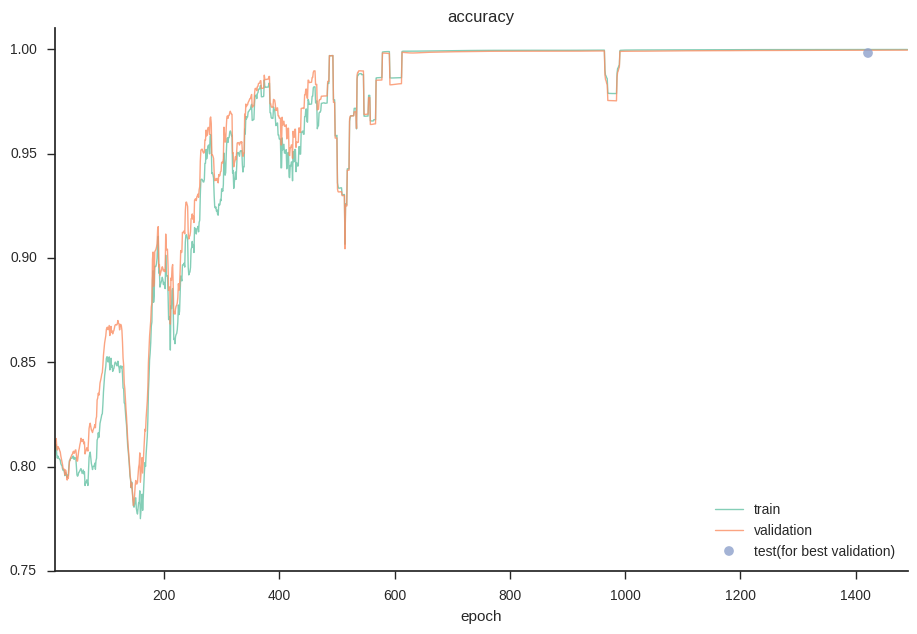

In [19]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'accuracy', smoothing=21)

### Precision/Recall

(<matplotlib.figure.Figure at 0x7f341c8feba8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3415e645c0>)

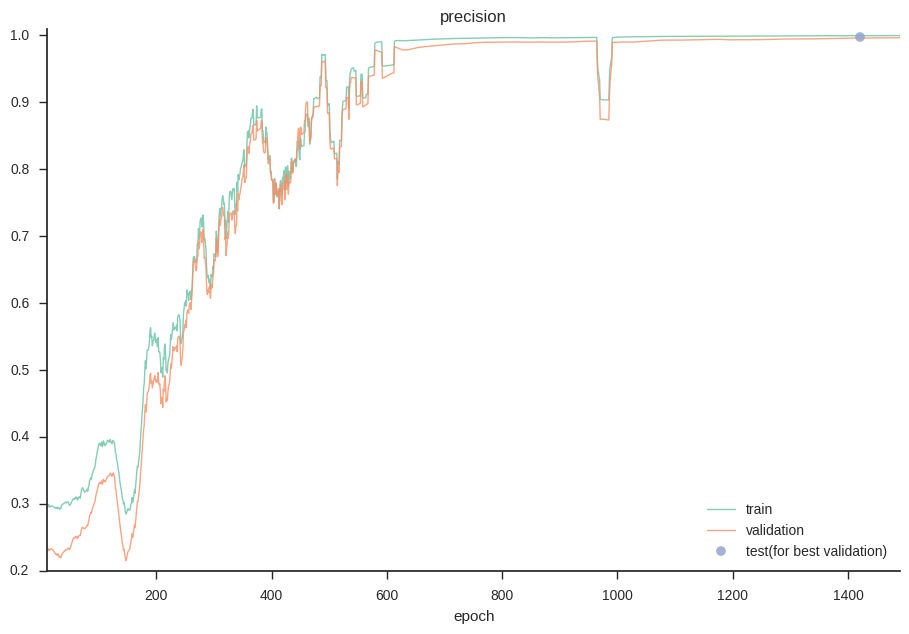

In [20]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'precision', smoothing=21)

(<matplotlib.figure.Figure at 0x7f34161dcba8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f341615bc18>)

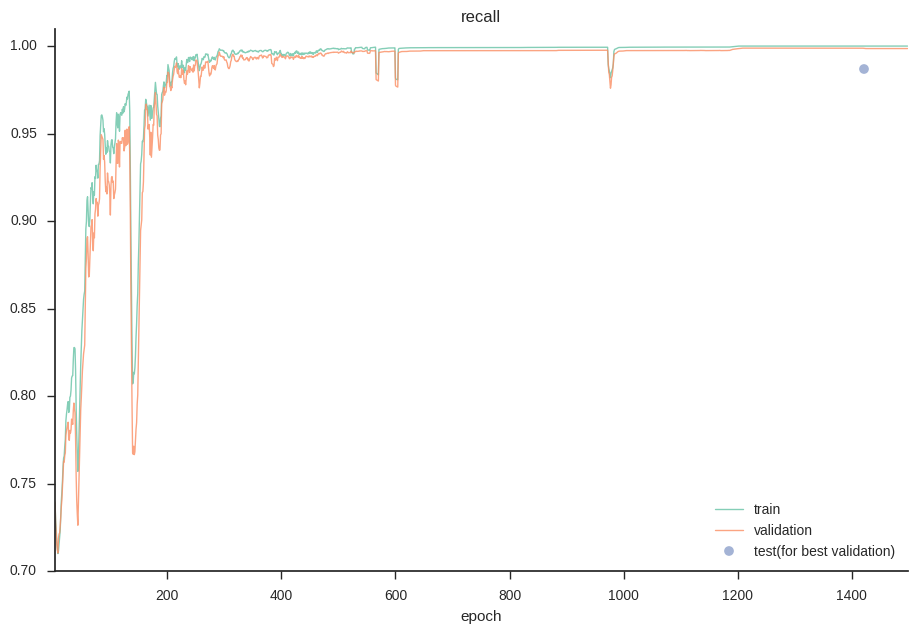

In [14]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'recall', smoothing=5)

### F1-Score

(<matplotlib.figure.Figure at 0x7f341fdc4b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f341f5ec5c0>)

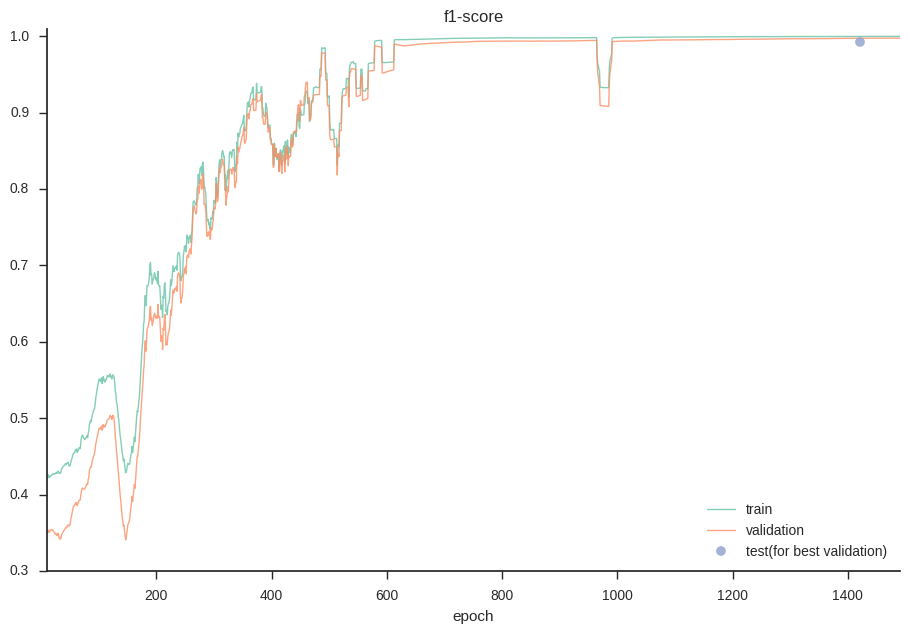

In [21]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'f1-score', smoothing=21)

### Misc stats

In [16]:
# see the best values indxes for validation
validation_stats.idxmax()

accuracy         1420
epoch            1499
f1-score         1420
precision        1433
recall           1205
support             0
support_other       0
dtype: int64

In [17]:
# also, here are the stats averaged over a rolling window of 50, resample in 50 steps
validation_stats.rolling(21, center=True).mean().dropna().iloc[1000::20].drop('epoch', axis=1)

,accuracy,f1-score,precision,recall,support,support_other
1010,0.999128,0.993617,0.989894,0.997367,4106.0,56222.0
1030,0.999131,0.993639,0.989962,0.997344,4106.0,56222.0
1050,0.999213,0.994237,0.991160,0.997333,4106.0,56222.0
1070,0.999294,0.994823,0.992293,0.997367,4106.0,56222.0
1090,0.999319,0.995008,0.992670,0.997356,4106.0,56222.0
1110,0.999322,0.995031,0.992682,0.997391,4106.0,56222.0
1130,0.999346,0.995209,0.993026,0.997402,4106.0,56222.0
1150,0.999376,0.995428,0.993485,0.997379,4106.0,56222.0
1170,0.999401,0.995607,0.993829,0.997391,4106.0,56222.0
1190,0.999398,0.995586,0.993225,0.997959,4106.0,56222.0


In case we need them later, we will persist the results.

In [22]:
pd.concat([train_stats.assign(set='train'), 
           validation_stats.assign(set='validation'), 
           test_stats.assign(set='test')]).to_csv('../data/experimental-results/cleaneval-validation-curves.csv')

## Conclusion
The validation curves look solid, an by looking at the indexes of the beest performanes on the validation set it looks like aroun the 1200-1400 mark, the performance seems to taper off and decrease. The performance is very good, but further confirmation should be done on different splits to have more statistically sound results.

The high similarity between the accuracy and precision could probably be traced to how skewed the dataset is, therefore small changes in performance on the training set would trainslate into changes for the other partitions as well due to the predominance of the negative class.